Наша команда состоит из Прозоровой Екатерина, Годуновой Анастасии, Горбиковой Алины, Насулецкого Александра и Чересовой Алены.
Далее будет представлен EDA:  
+ определение цели анализа (что хотим понять, на какие вопросы будем отвечать?),  
+ работа с пропусками,
+ выявление зависимостей,
+ создание новых переменных,
+ сортировка, фильтрация, группировка,
+ определение и работа с выбросами,
+ проверка гипотез,
+ визуализация,
+ выводы.

Для начала проводим все стандартные процедуры – импортируем потенциально необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import missingno as nsno

import pylab #аккумулирует нумпай и матплотлиб
import scipy #научный датасет
from scipy import stats
import statsmodels.api as sm

In [2]:
df = pd.read_excel('E Commerce Dataset.xlsx')

Знакомимся с нашим датасетом. Выполним основные команды

In [3]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
df.shape

(5630, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

Когда мы проверили, что все загрузилось и корректно выводится, посмотрим, какие у нас есть переменные и что они обозначают

**Описание переменных**
+ **CustomerID** - Уникальный идентификатор клиента
+ **Churn** - Флаг оттока
+ **Tenure** - Срок пребывания клиента в организации
+ **PreferredLoginDevice** - Предпочитаемое устройство входа в систему клиента
+ **CityTier** - Тип города
+ **WarehouseToHome** - Расстояние от склада до дома клиента
+ **PreferredPaymentMode** - Предпочитаемый способ оплаты клиента
+ **Gender** - Пол клиента
+ **HourSpendOnApp** - Количество часов, проведенных в мобильном приложении или на сайте
+ **NumberOfDeviceRegistered** - Общее количество девайсов, зарегистрированных на конкретного клиента
+ **PreferedOrderCat** - Предпочитаемая категория заказов клиента за последний месяц
+ **SatisfactionScore** - Оценка клиента по обслуживанию
+ **MaritalStatus** - Семейное положение клиента
+ **NumberOfAddress** - Общее количество добавлений на конкретного клиента
+ **Complain** - Была ли подана жалоба в прошлом месяце
+ **OrderAmountHikeFromlastYear** - Процентное увеличение заказов по сравнению с прошлым годом
+ **CouponUsed** - Общее количество купонов, использованных в прошлом месяце
+ **OrderCount** - Общее количество заказов в прошлом месяце
+ **DaySinceLastOrder** - День с момента последнего заказа клиента
+ **CashbackAmount** - Средний cashback в прошлом месяце

То есть нам предоставлены данные по клиентам маркетплейса. Важно отметить, что мы заранее предполагаем, что это лишь выгрузка части базы клиентов (выборка, а не генеральная совокупность клиентов маркетплейса).

Также тут важно отметить, что мы заметили, что в некоторых столбцах в датасете есть проблемы, а именно в переменных Tenure, WarehouseToHome, HourSpendOnApp, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder. При работы с ними пропуски мы будем чистить.

Сформулируем вопросы, на которые мы сможем ответить:

1. **Анализ оттока и удовлетворенности:**
   - Посчитать общий процент оттока клиентов (Сhurn) и процент оттока по полу (Gender).
   - Исследовать зависимость оттока (Сhurn) от уровня удовлетворенности клиентов (SatisfactionScore).
   - Исследовать зависимость подачи жалобы в прошлом месяце (Complain) от уровня удовлетворенности клиентов (SatisfactionScore).
   
2. **Любимые категории товаров:**
   - Определить, какие категории заказов (PreferedOrderCat) наиболее популярны среди клиентов. 
   - Определить какие категории заказов (PreferedOrderCat) больше всего популярны у женщин и популярны у мужчин (Gender).

3. **Характеристики платформы маркетплейса:**
   - Исследовать, как предпочитаемое устройство входа в систему (PreferredLoginDevice) влияет на уровень удовлетворенности (SatisfactionScore).
   - Проанализировать переменную (HourSpendOnApp). Исследовать есть ли в ней выбросы.

4. **Оплаты и купоны:**
   - Исследовать предпочтения по способам оплаты (PreferredPaymentMode), выделить, каким способом чаще пользуются.
   - Исследовать предпочтения по способам оплаты (PreferredPaymentMode) и любимым категориям (PreferedOrderCat).
   - Исследовать использование купонов (CouponUsed) и посмотреть на использование купонов в отношении заказов в прошлом месяце (OrderCount).
   - Исследовать завимость использования купонов (CouponUsed) от пола (Gender).
   
5. **Кешбеки:**
   - Исследовать средний кешбек (CashbackAmount), убрать выбросы
   - Исследовать связан ли отток (Сhurn) с полученным кешбеком.
   - Посмотерть если ли зависимость между полученным кешбеком (CashbackAmount) и сроком жизни клеинта в организации (Tenure). 

5. **Расстояние и заказы:**
   - Исследовать расстояние от склада до дома (WarehouseToHome), убрать выбросы, посмотреть корреляцию с количеством заказов.
   - Исследовать, как тип города (CityTier) влияет расстояние от склада до дома (WarehouseToHome).

8. **Выводы и рекомендации:**
    - Сделайте общие выводы о клиентском поведении, предложите стратегии удержания и улучшения обслуживания.


# Анализ оттока

In [6]:
#Для начала выведем описательную статистику по всем переменным, для изучения.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,5630.0,52815.500000,1625.385339,50001.0,51408.25,52815.50,54222.7500,55630.00
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.0000,1.00
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.00,16.0000,61.00
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,3.0000,3.00
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.00,20.0000,127.00
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.00,3.0000,5.00
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.00,4.0000,6.00
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.00,4.0000,5.00
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.00,6.0000,22.00
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,1.0000,1.00


In [7]:
#Начнем с анализа оттока пользователей. Посчитаем средний процент оттока:
churn_mean = df.Churn.mean()*100
churn_mean 

16.838365896980463

In [8]:
#Интересно,а какой процент оттока для мужчин и женщин? Посчитаем и выведем с помощью графика
churn_gender = df.groupby('Gender')['Churn'].mean() *100
churn_gender

Gender
Female    15.494212
Male      17.730496
Name: Churn, dtype: float64

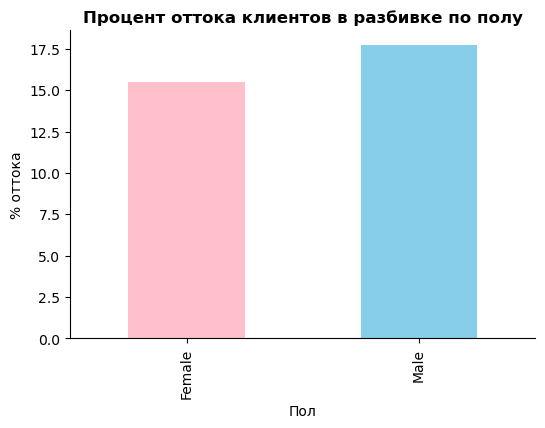

In [9]:
#Строим график
fig1, ax = plt.subplots(figsize = (6,4))
churn_gender.plot( kind = 'bar', ax = ax, color = ['pink', 'skyblue'])
ax.set_ylabel('% оттока')
ax.set_xlabel('Пол')
ax.set_title('Процент оттока клиентов в разбивке по полу', fontweight ='bold')
#Убираем ненужные очертания
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [10]:
#Сохраняем график, так как он понадобится нам в презентации
fig1.savefig('churn_gender.pdf')

Таким образом мы видим, что всего по базе клиентов в среднем оттекли 16.8% клиентов, причем у мужчин % оттока выше.

In [11]:
#Теперь изучим переменную SatisfactionScore
df['SatisfactionScore'].describe()

count    5630.000000
mean        3.066785
std         1.380194
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: SatisfactionScore, dtype: float64

Видим, что оценки распределены по 5бальной шкале, средняя оценка чуть больше 3.

<Axes: >

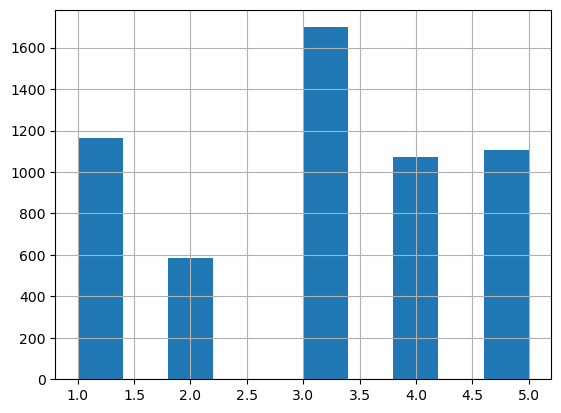

In [12]:
#Посмотрим, как распределены наши оценки.
df['SatisfactionScore'].hist()

In [13]:
#Будем использовать непараметрические критерии, так как это уровень удовоетворенности. 
#Нам как бизнесу скорее важен именно уровень удовлетворенности.
#Поэтому предположим, что если клиент поставил 1, 2 или 3, он не удовлетворен, и 4-5 - удовлетворен.
#Создадим новый столбец в нашем датасете с этой информацией, для начала зададим фунцией
def get_satisfaction_cat(x):
    if x <= 3:
        return 'Клиент не удовлетворен'
    elif x > 3:
        return 'Клиент удовлетворен'
    else:
        return '99999'

#Применем функцию к нашему столбцу SatisfactionScore и создадим новый столбец.
df['Satisfaction_cat'] = df['SatisfactionScore'].apply(get_satisfaction_cat)
df[:1]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,2,Single,9,1,11.0,1.0,1.0,5.0,159.93,Клиент не удовлетворен


In [14]:
#Теперь выведем нашу таблицу, где сгруппируем клиентов по флагу оттока, и сразу выведем таблицу сопряженности
df.groupby('Satisfaction_cat')['Churn'].value_counts().unstack()

Churn,0,1
Satisfaction_cat,,
Клиент не удовлетворен,2948,500
Клиент удовлетворен,1734,448


In [15]:
#Проверим гипотезу, что уровень удовлетворенности влияет на отток.
#H0 - уровень удовлетворенности не влияет на отток
#H1 - уровень удовлетворенности влияет на отток
#Будем использовать критерий незавимиости хи квардрат, чтобы проверить данную гипотезу.
ct_o=df.groupby('Satisfaction_cat')['Churn'].value_counts().unstack()
scipy.stats.chi2_contingency(ct_o,correction = False)

Chi2ContingencyResult(statistic=34.70498500338607, pvalue=3.836479263089359e-09, dof=1, expected_freq=array([[2867.41314387,  580.58685613],
       [1814.58685613,  367.41314387]]))

In [16]:
#Зададим наши переменные, и проверим гипотезу
chi2, pval, dof, expected = scipy.stats.chi2_contingency(ct_o,correction = False)
alpha = 0.05
crit_val = scipy.stats.chi2.ppf(0.95,1) #1 это степени свободы, тк матрица у нас 2 на 2
if chi2 >= crit_val: 
    print ('H0 отвергаем, уровень удовлетворенности влияет на отток')
else:
        print ('H0 не отвергаем, уровень удовлетворенности не влияет на отток')

H0 отвергаем, уровень удовлетворенности влияет на отток


Таким образом мы сделали интересный вывод, что уровень удовлетворенности влияет на отток клиентов, что логично.

In [17]:
#Теперь посмотрим влияет ли флаг подачи жалобы в прошлом месяце на уровень удовлетворенности.
df.groupby('Complain')['Satisfaction_cat'].value_counts().unstack()

Satisfaction_cat,Клиент не удовлетворен,Клиент удовлетворен
Complain,,
0,2434,1592
1,1014,590


In [18]:
#Проверим гипотезу, что флаг подачи жалобы в прошлом месяце влияет на уровень удовлетворенности..
#H0 - флаг подачи жалобы в прошлом месяце не влияет на уровень удовлетворенности
#H1 - флаг подачи жалобы в прошлом месяце влияет на уровень удовлетворенности
#Будем использовать критерий незавимиости хи квардрат, чтобы проверить данную гипотезу.
ct_o=df.groupby('Complain')['Satisfaction_cat'].value_counts().unstack()
scipy.stats.chi2_contingency(ct_o,correction = False)
chi2, pval, dof, expected = scipy.stats.chi2_contingency(ct_o,correction = False)
alpha = 0.05
crit_val = scipy.stats.chi2.ppf(0.95,1) #1 это степени свободы, тк матрица у нас 2 на 2
if chi2 >= crit_val: 
    print ('H0 отвергаем, флаг подачи жалобы в прошлом месяце влияет на уровень удовлетворенности')
else:
        print ('H0 не отвергаем, флаг подачи жалобы в прошлом месяце не влияет на уровень удовлетворенности')

H0 не отвергаем, флаг подачи жалобы в прошлом месяце не влияет на уровень удовлетворенности


Тем не менее, нет завимимости в подаче жалоб и оттоке клиентов.

# Любимые категории

In [19]:
#Теперь посмотрим, какие категории заказов (PreferedOrderCat) наиболее популярны среди клиентов. И визуализируем полученные результаты.
POC = df['PreferedOrderCat'].value_counts()
print(("Категории товаров, отсортированные по популярности у клиентов"), POC)

Категории товаров, отсортированные по популярности у клиентов PreferedOrderCat
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: count, dtype: int64


In [20]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,2,Single,9,1,11.0,1.0,1.0,5.0,159.93,Клиент не удовлетворен
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,...,3,Single,7,1,15.0,0.0,1.0,0.0,120.90,Клиент не удовлетворен
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,...,3,Single,6,1,14.0,0.0,1.0,3.0,120.28,Клиент не удовлетворен
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,...,5,Single,8,0,23.0,0.0,1.0,3.0,134.07,Клиент удовлетворен
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,...,5,Single,3,0,11.0,1.0,1.0,3.0,129.60,Клиент удовлетворен


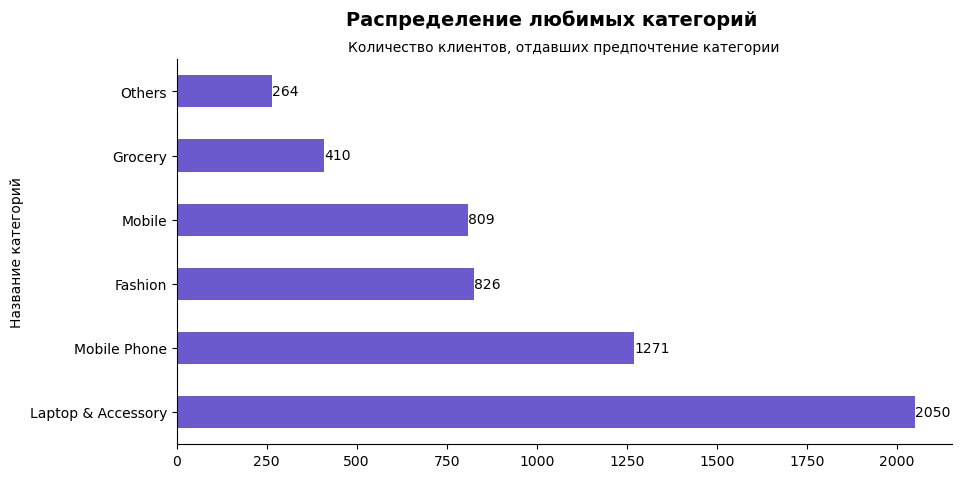

In [21]:
#Рисуем наш графики
fig2, ax = plt.subplots(figsize = (10,5))
ax = POC.plot(kind = 'barh', color = 'slateblue')
ax.bar_label(ax.containers[0],fontsize = 10)
#Подптсываем графики
plt.ylabel ('Название категорий', fontsize = 10)
plt.title ('Количество клиентов, отдавших предпочтение категории', fontsize = 10)
plt.suptitle('Распределение любимых категорий', fontweight ='bold', fontsize = 14)
#Убираем ненужные очертания
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [22]:
#Сохраняем график, так как он понадобится нам в презентации
fig2.savefig('POC.pdf')

In [23]:
#Теперь посмотрим популярные категории в зависимости от пола клиента.
#Сначала создадим 2 переременные только в мужчинами и только с женщинами, они нам в дольшейшем могут понадобиться.
df_male = df[df['Gender']=='Male']
df_female = df[df['Gender']=='Female']

In [24]:
#Теперь посчитаем популярные категории и визализируем результаты.
POC_male = df_male['PreferedOrderCat'].value_counts()
POC_female = df_female['PreferedOrderCat'].value_counts()

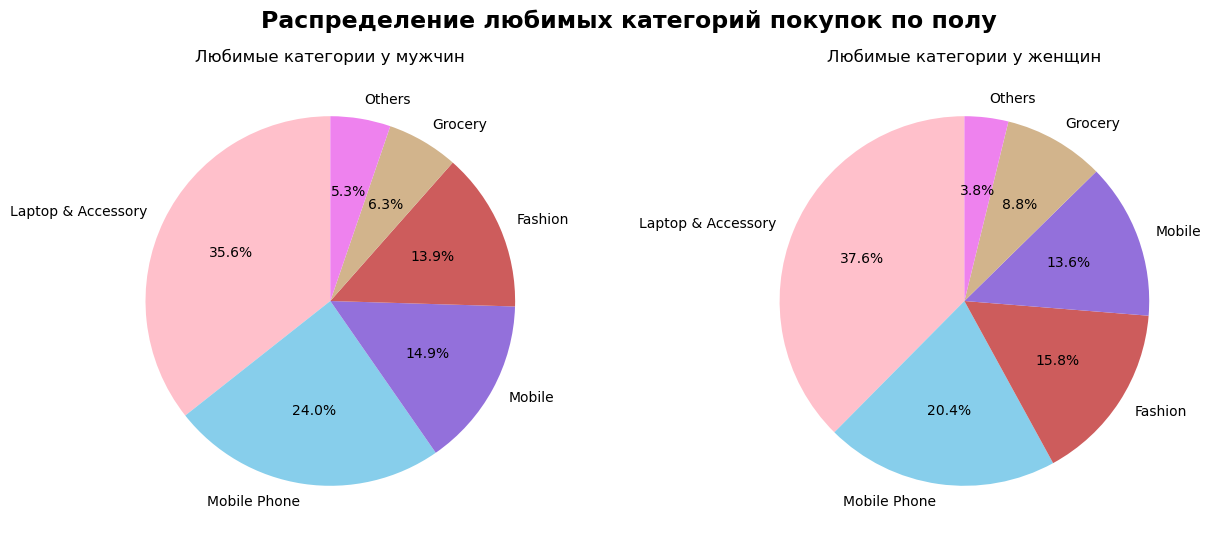

In [25]:
#Выведем 2 графика рядом, чтобы удобнее сравнивать
fig3, ax = plt.subplots(1, 2, figsize=(15, 6))

#Рисуем первый pie chart POC_male
POC_male.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = ['pink', 'skyblue', 'mediumpurple', 'indianred', 'tan', 'violet'], ax=ax[0])
ax[0].set_title('Любимые категории у мужчин')
ax[0].set_ylabel('') 

#Рисуем второй pie chart POC_female
POC_female.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['pink', 'skyblue', 'indianred', 'mediumpurple', 'tan', 'violet'], ax=ax[1])
ax[1].set_title('Любимые категории у женщин')
ax[1].set_ylabel('') 

plt.suptitle('Распределение любимых категорий покупок по полу', fontweight ='bold', fontsize = 17)
plt.show()

In [26]:
#Опять же сохраняем график, так как он понадобится нам в презентации
fig3.savefig('POC_gender.pdf')

Видно, что мужчин больше инетерсуют мобильные телефоны, а женщин больше продукты.

# Характеристики платформы маркетплейса

In [27]:
#Посмотрим, с каких устройств клиенты заходят на наш маркетплейс
df['PreferredLoginDevice'].unique()

array(['Mobile Phone', 'Phone', 'Computer'], dtype=object)

In [28]:
#Видим, что у нас есть 2 типа телефона, но на самом деле это скорее всего один общий тип, который наша истсема логировала неправильно.
#Не будем удалять этот столбец, но создадим новый, где оставим 2 категории: Phone, Computer

def get_logdev_cat(x):
    if x == 'Mobile Phone' or x == 'Phone':
        return 'Phone'
    else:
        return 'Computer'

#Применем функцию к нашему столбцу SatisfactionScore и создадим новый столбец.
df['PreferredLoginDeviceTrue'] = df['PreferredLoginDevice'].apply(get_logdev_cat)
df[:10]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat,PreferredLoginDeviceTrue
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,Single,9,1,11.0,1.0,1.0,5.0,159.93,Клиент не удовлетворен,Phone
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,...,Single,7,1,15.0,0.0,1.0,0.0,120.90,Клиент не удовлетворен,Phone
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,...,Single,6,1,14.0,0.0,1.0,3.0,120.28,Клиент не удовлетворен,Phone
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,...,Single,8,0,23.0,0.0,1.0,3.0,134.07,Клиент удовлетворен,Phone
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,...,Single,3,0,11.0,1.0,1.0,3.0,129.60,Клиент удовлетворен,Phone
5,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,...,Single,2,1,22.0,4.0,6.0,7.0,139.19,Клиент удовлетворен,Computer
6,50007,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,...,Divorced,4,0,14.0,0.0,1.0,0.0,120.86,Клиент не удовлетворен,Phone
7,50008,1,NaN,Phone,1,6.0,CC,Male,3.0,3,...,Divorced,3,1,16.0,2.0,2.0,0.0,122.93,Клиент не удовлетворен,Phone
8,50009,1,13.0,Phone,3,9.0,E wallet,Male,NaN,4,...,Divorced,2,1,14.0,0.0,1.0,2.0,126.83,Клиент не удовлетворен,Phone
9,50010,1,NaN,Phone,1,31.0,Debit Card,Male,2.0,5,...,Single,2,0,12.0,1.0,1.0,1.0,122.93,Клиент не удовлетворен,Phone


In [29]:
PreferredLoginDeviceTrue_vis = df['PreferredLoginDeviceTrue'].value_counts()
PreferredLoginDeviceTrue_vis

PreferredLoginDeviceTrue
Phone       3996
Computer    1634
Name: count, dtype: int64

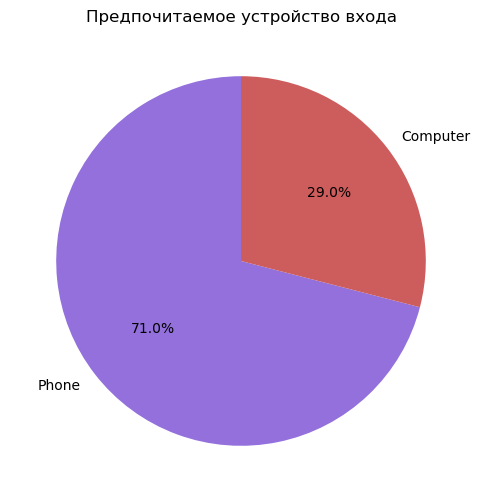

In [30]:
#Попробуем визуализировать предпочитаемое устройство входа.
fig4, ax = plt.subplots(figsize=(6, 6))
PreferredLoginDeviceTrue_vis.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = [ 'mediumpurple', 'indianred'])
plt.title('Предпочитаемое устройство входа')
plt.ylabel('') 
plt.savefig('Предпочитаемое устройство входа.pdf', format='pdf')

In [31]:
#Теперь посмотрим, как распределяется уровень удовлетворенности у клиентов по устройству.
df.groupby('PreferredLoginDeviceTrue')['Satisfaction_cat'].value_counts().unstack()

Satisfaction_cat,Клиент не удовлетворен,Клиент удовлетворен
PreferredLoginDeviceTrue,,
Computer,1054,580
Phone,2394,1602


In [32]:
#Проверим гипотезу, что девайс не влияет на уровень удовлетворенности.
#H0 - девайс не влияет на уровень удовлетворенности.
#H1 - девайс влияет на уровень удовлетворенности.
#Будем использовать критерий незавимиости хи квардрат, чтобы проверить данную гипотезу.
ct_o=df.groupby('PreferredLoginDeviceTrue')['Satisfaction_cat'].value_counts().unstack()
scipy.stats.chi2_contingency(ct_o,correction = False)

Chi2ContingencyResult(statistic=10.313750587976191, pvalue=0.0013204265851122668, dof=1, expected_freq=array([[1000.71616341,  633.28383659],
       [2447.28383659, 1548.71616341]]))

In [33]:
#Зададим наши переменные, и проверим гипотезу
chi2, pval, dof, expected = scipy.stats.chi2_contingency(ct_o,correction = False)
alpha = 0.05
crit_val = scipy.stats.chi2.ppf(0.95,1) #1 это степени свободы, тк матрица у нас 2 на 2
if chi2 >= crit_val: 
    print ('H0 отвергаем, девайс влияет на уровень удовлетворенности')
else:
        print ('H0 не отвергаем, девайс влияет на уровень удовлетворенности')

H0 отвергаем, девайс влияет на уровень удовлетворенности


Таким образом, мы видим, что у нас есть зависимость от девайса и уровня удовлетворенности.

In [34]:
#Еще проверим, сколько вообще клиенты времени проводят на нашем маркетплейсе.
#Когда мы изучали наш датасет в начале, мы видели, что у нем есть пропуски.
#В переменной HourSpendOnApp тоже есть пропуски, поэтому удалим их.
df2 = df.dropna(subset=['HourSpendOnApp'])
df2.shape

(5375, 22)

In [35]:
#Посмотрим на основные значения.
df2['HourSpendOnApp'].describe()

count    5375.000000
mean        2.931535
std         0.721926
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: HourSpendOnApp, dtype: float64

<Axes: >

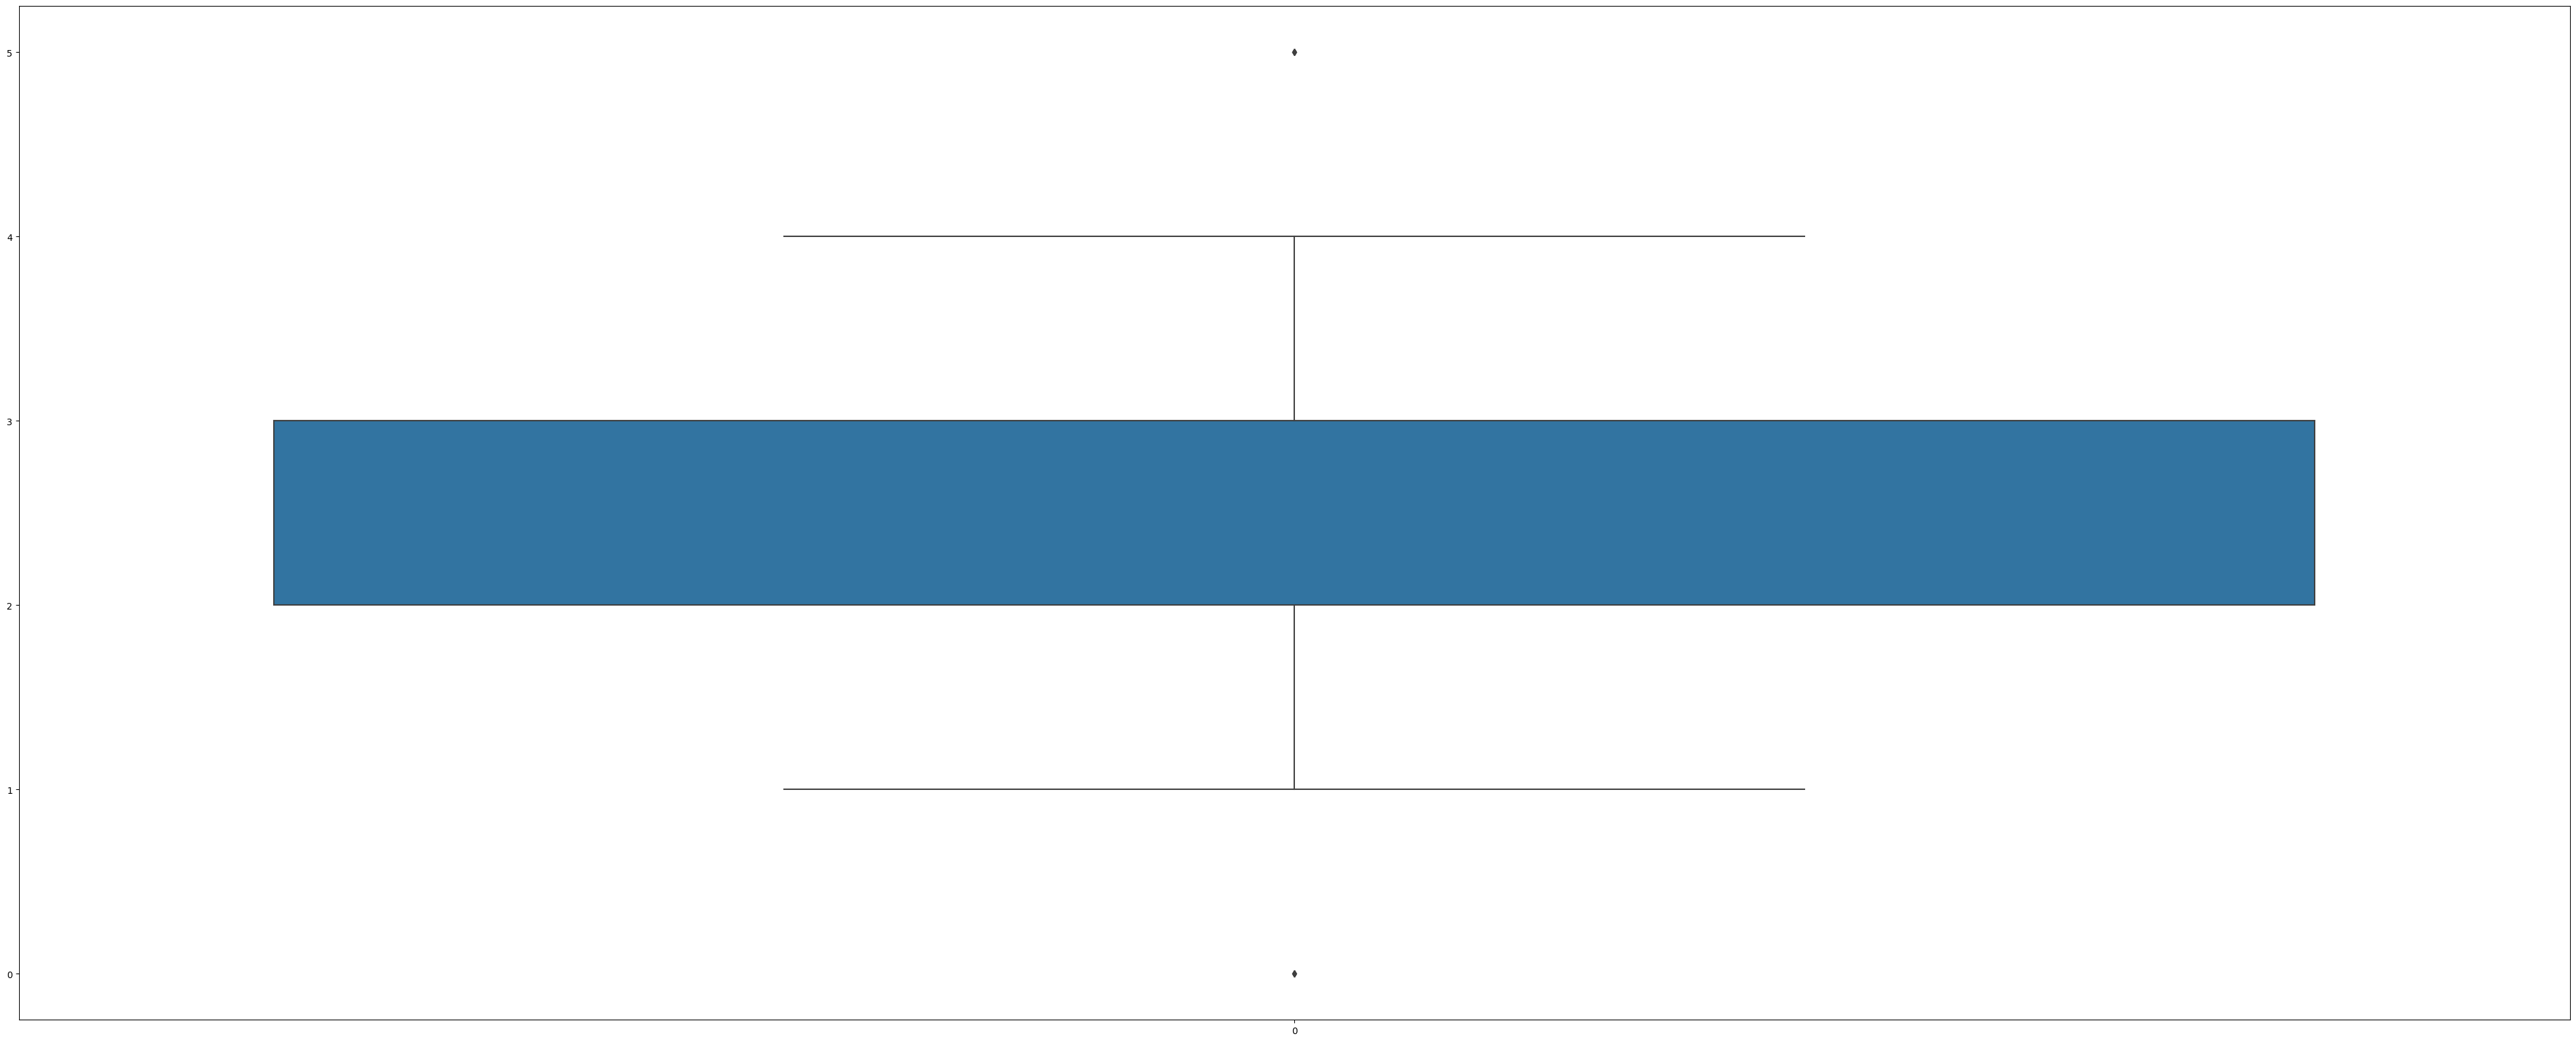

In [36]:
#Мы видим, что в среднем клиенты проводят по 2,9 часа. Интересно есть ли у нас выбросы?
plt.figure(figsize = (50,20))
sns.boxplot(data=df2['HourSpendOnApp'])

In [37]:
#Видим, что есть, интересно, что это за выбросы?
#Найдем z оценку, то есть на сколько стандартных отклонений отличаются значения
zscore = scipy.stats.zscore(df2['HourSpendOnApp'])
zscore

0       0.094846
1       0.094846
2      -1.290467
3      -1.290467
5       0.094846
          ...   
5625    0.094846
5626    0.094846
5627    0.094846
5628    1.480158
5629    0.094846
Name: HourSpendOnApp, Length: 5375, dtype: float64

In [38]:
#И посмотрим на выбросы
vybrosi = df2[~(zscore.abs()<3)]
vybrosi

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat,PreferredLoginDeviceTrue
150,50151,0,10.0,Computer,1,6.0,Credit Card,Female,0.0,3,...,Married,3,1,18.0,0.0,NaN,2.0,236.03,Клиент не удовлетворен,Computer
950,50951,0,5.0,Mobile Phone,1,16.0,Credit Card,Male,0.0,3,...,Single,3,0,25.0,0.0,1.0,NaN,212.44,Клиент не удовлетворен,Phone
1950,51951,0,11.0,Computer,1,18.0,Debit Card,Male,0.0,4,...,Married,3,0,15.0,1.0,1.0,2.0,162.88,Клиент удовлетворен,Computer


In [39]:
#Посмотрим то же самое через интерквартильный размах
q3 = np.percentile(df2['HourSpendOnApp'],75)
q1 = np.percentile(df2['HourSpendOnApp'],25)
iqr = q3 - q1 #ищем интерквартильный размах
print(iqr)

1.0


In [40]:
#Ищем верхнюю и нижнюю границы
iqr_lower_level = q1 - 1.5*iqr
iqr_upper_level = q3 + 1.5*iqr
print(iqr_lower_level,iqr_upper_level)

0.5 4.5


In [41]:
#Опять смотрим на выбросы
vybrosi_2 = df2[(df2['HourSpendOnApp'] > iqr_upper_level) | (df2['HourSpendOnApp'] < iqr_lower_level)]
vybrosi_2

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat,PreferredLoginDeviceTrue
150,50151,0,10.0,Computer,1,6.0,Credit Card,Female,0.0,3,...,Married,3,1,18.0,0.0,NaN,2.0,236.03,Клиент не удовлетворен,Computer
950,50951,0,5.0,Mobile Phone,1,16.0,Credit Card,Male,0.0,3,...,Single,3,0,25.0,0.0,1.0,NaN,212.44,Клиент не удовлетворен,Phone
1950,51951,0,11.0,Computer,1,18.0,Debit Card,Male,0.0,4,...,Married,3,0,15.0,1.0,1.0,2.0,162.88,Клиент удовлетворен,Computer
4223,54224,0,31.0,Mobile Phone,3,32.0,Debit Card,Female,5.0,4,...,Single,9,0,12.0,7.0,8.0,10.0,201.37,Клиент удовлетворен,Phone
4248,54249,0,4.0,Mobile Phone,1,9.0,Debit Card,Male,5.0,5,...,Married,3,0,20.0,4.0,11.0,9.0,166.52,Клиент не удовлетворен,Phone
4351,54352,0,1.0,Phone,1,16.0,Credit Card,Female,5.0,4,...,Single,3,0,17.0,1.0,2.0,4.0,147.79,Клиент удовлетворен,Phone


Таким образом, мы посмотрели, что есть выбросы во времени на маркетплейсе - это люди, которые вообще не заходили (0 часов) и люди, которые провери на нашем маркетплейсе целых 5 часов.

## Оплаты и купоны

In [42]:
#Теперь посмотрим на оплату клиентами, сначала изучим, какие вообще есть способы оплаты
df['PreferredPaymentMode'].unique()

array(['Debit Card', 'UPI', 'CC', 'Cash on Delivery', 'E wallet', 'COD',
       'Credit Card'], dtype=object)

In [43]:
#Опять видим, что некоторые способы оплаты дублируются полным названием и сокращенным.
#То есть 'Cash on Delivery' = 'COD', а 'Credit Card' = 'CC', опять приведем данные к одним названиям.
#При этом прошлый столбец удалять не будем, создадим новый

def get_paymodetrue_cat(x):
    if x == 'Debit Card':
        return 'Debit Card'
    elif x == 'UPI':
        return 'UPI'
    elif x == 'CC' or x == 'Credit Card':
        return 'Credit Card'
    elif x == 'Cash on Delivery' or x == 'COD':
        return 'Cash on Delivery'
    else:
        return 'E wallet'

#Применем функцию к нашему столбцу SatisfactionScore и создадим новый столбец.
df['PreferredPaymentModeTrue'] = df['PreferredPaymentMode'].apply(get_paymodetrue_cat)
df[:10]


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat,PreferredLoginDeviceTrue,PreferredPaymentModeTrue
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,9,1,11.0,1.0,1.0,5.0,159.93,Клиент не удовлетворен,Phone,Debit Card
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,...,7,1,15.0,0.0,1.0,0.0,120.90,Клиент не удовлетворен,Phone,UPI
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,...,6,1,14.0,0.0,1.0,3.0,120.28,Клиент не удовлетворен,Phone,Debit Card
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,...,8,0,23.0,0.0,1.0,3.0,134.07,Клиент удовлетворен,Phone,Debit Card
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,...,3,0,11.0,1.0,1.0,3.0,129.60,Клиент удовлетворен,Phone,Credit Card
5,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,...,2,1,22.0,4.0,6.0,7.0,139.19,Клиент удовлетворен,Computer,Debit Card
6,50007,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,...,4,0,14.0,0.0,1.0,0.0,120.86,Клиент не удовлетворен,Phone,Cash on Delivery
7,50008,1,NaN,Phone,1,6.0,CC,Male,3.0,3,...,3,1,16.0,2.0,2.0,0.0,122.93,Клиент не удовлетворен,Phone,Credit Card
8,50009,1,13.0,Phone,3,9.0,E wallet,Male,NaN,4,...,2,1,14.0,0.0,1.0,2.0,126.83,Клиент не удовлетворен,Phone,E wallet
9,50010,1,NaN,Phone,1,31.0,Debit Card,Male,2.0,5,...,2,0,12.0,1.0,1.0,1.0,122.93,Клиент не удовлетворен,Phone,Debit Card


In [44]:
#Проверим, что все нормально отработало и сравним данные.
#Также создадим новую перемнную, чтобы удобнее использовать ее для визуализации.
payment_mode_vis = df['PreferredPaymentModeTrue'].value_counts()
payment_mode_vis

PreferredPaymentModeTrue
Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: count, dtype: int64

In [45]:
#Все верно перегруппировалось.
df['PreferredPaymentMode'].value_counts()

PreferredPaymentMode
Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: count, dtype: int64

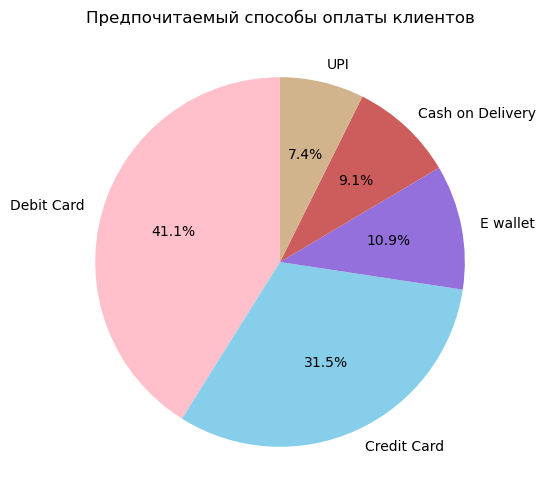

In [46]:
#Попробуем визуализировать любимый способ оплаты.
fig5, ax = plt.subplots(figsize=(6, 6))
payment_mode_vis.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = ['pink', 'skyblue', 'mediumpurple', 'indianred', 'tan', 'violet'])
plt.title('Предпочитаемый способы оплаты клиентов')
plt.ylabel('') 
plt.savefig('Предпочитаемый способы оплаты клиентов.pdf', format='pdf')

In [47]:
#Опять же сохраняем график, так как он понадобится нам в презентации
fig5.savefig('payment_mode_vis.pdf') 

Таким образом самые популярные способы оплаты это дебетовая и кредитная карточки.

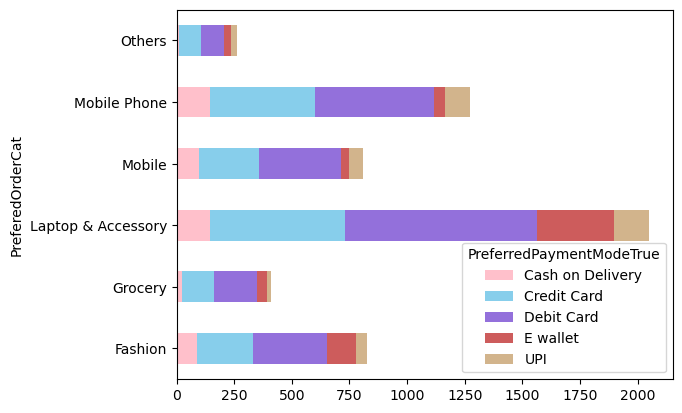

In [48]:
#Интересно, как распределяются способы оплаты по любимым категориям, кажется, что технику чаще будут покупать с кредитной карты.
#Визуализируем это на графике
df.groupby('PreferedOrderCat')['PreferredPaymentModeTrue'].value_counts().unstack().plot(kind= 'barh', stacked = True, color = ['pink', 'skyblue', 'mediumpurple', 'indianred', 'tan'])
plt.savefig('Распределение способов оплаты по любимым категориям.pdf', format='pdf')

Оказалось это не так, кредитной картой везде платят меньше, чем дебетовой.

In [49]:
#Теперь посмотрим на купоны, однако вспомним, что в этой переменной есть пропуски, и сразу их удалим.
df3 = df.dropna(subset=['CouponUsed'])
df3.shape

(5374, 23)

In [50]:
#Теперь посмотрим на основные хараектристики данной переменной.
df3['CouponUsed'].describe()

count    5374.000000
mean        1.751023
std         1.894621
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        16.000000
Name: CouponUsed, dtype: float64

In [51]:
#Посмотрим еще как в перцентялях распределяется использование купонов.
df3['CouponUsed'].describe(percentiles = [.01, .05, .10, .15, .20, .25, .30, .35, .40, .45, .50, .55, .60, .65, .70, .75, .80, .85, .90, .95, .99, 1])

count    5374.000000
mean        1.751023
std         1.894621
min         0.000000
1%          0.000000
5%          0.000000
10%         0.000000
15%         0.000000
20%         1.000000
25%         1.000000
30%         1.000000
35%         1.000000
40%         1.000000
45%         1.000000
50%         1.000000
55%         1.000000
60%         2.000000
65%         2.000000
70%         2.000000
75%         2.000000
80%         2.000000
85%         3.000000
90%         4.000000
95%         6.000000
99%         9.000000
100%       16.000000
max        16.000000
Name: CouponUsed, dtype: float64

Таким образом 95% клиентов использовали меньше 6 купонов в прошлом месяце. Попробуем сгруппировать датасет по количеству заказов в прошлом месяце и по использованным купонам.

In [52]:
#Но опять же вопомним, что у нас есть пропуски, поэтому почистим датасет от пропусков в 'OrderCount'
df4 = df3.dropna(subset=['OrderCount'])
df4.shape

(5116, 23)

In [53]:
coupon_order = df4.groupby('OrderCount')['CouponUsed'].value_counts().unstack()
coupon_order

CouponUsed,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
OrderCount,,,,,,,,,,,,,,,,,
1.0,832.0,854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,79.0,922.0,962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,23.0,104.0,104.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,16.0,37.0,42.0,38.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,13.0,33.0,27.0,37.0,31.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,5.0,16.0,21.0,20.0,20.0,26.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,13.0,19.0,24.0,27.0,30.0,19.0,33.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,3.0,17.0,16.0,25.0,18.0,19.0,22.0,21.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,6.0,7.0,2.0,10.0,5.0,5.0,11.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


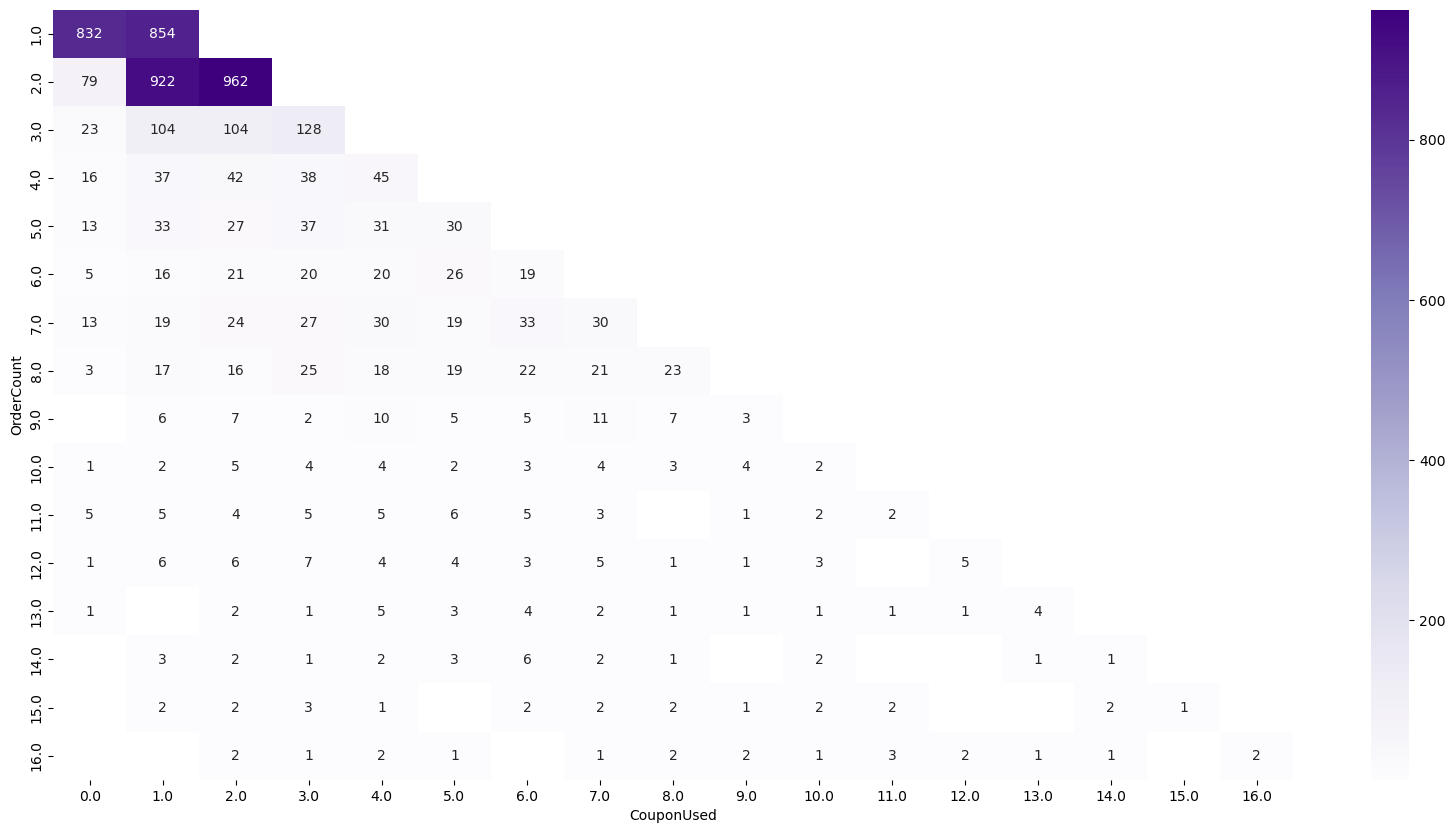

In [54]:
plt.figure(figsize=(20,10))
sns.heatmap(data = coupon_order, annot = True, cmap = 'Purples', fmt=',.0f') #fmt=',.0f' - целые числа
plt.savefig('Тепловая карта.pdf', format='pdf')

Таким образом мы видим, что среди людей, которые заказывали 1 раз больше тех, кто воспользовался купоном. Также среди людей, кто заказывал 2 раза, больше тех, кто 2 раза воспользовался купоном.

In [55]:
#Теперь будет исследовать завимость использования купонов (CouponUsed) от пола (Gender).
#Будем проверять эту гипотезу.
df3_male = df3[df3['Gender']=='Male']
df3_female = df3[df3['Gender']=='Female']
men_coupon = df3_male['CouponUsed']
women_coupon = df3_female['CouponUsed']
print (men_coupon.mean(), women_coupon.mean() )

1.6919052016004925 1.8414117647058823


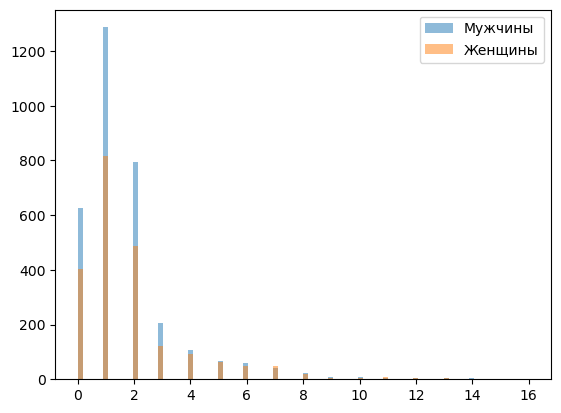

In [56]:
#Посмотрим, как распределено использование купонов у мужчин и у женщин
plt.hist(men_coupon, label = 'Мужчины', bins = 90, alpha = 0.5)
plt.hist(women_coupon, label = 'Женщины', bins = 90, alpha = 0.5)
plt.legend()
plt.show()

In [57]:
#Проверим нормальное ли распределение у мужчин c помощью теста Шапира Уилка
stats.shapiro(men_coupon)
Stat, p_value = stats.shapiro(men_coupon)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

Распределение не соответствует признакам нормальности


In [58]:
#Проверим нормальное ли распределение у мужчин c помощью теста Колмогорова-Смирнова
stat, p_value = stats.kstest(men_coupon, 'norm')
alpha = 0.05
if p_value > alpha:
    print ('H0 не отвергаем, распределение - нормальное')
else:
    print('Распределение не соотвествует признакам нормальности')

Распределение не соотвествует признакам нормальности


(array([ 0.74450046,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.48900092,  0.74450046,  1.48900092,  2.23350137,
         3.72250229,  1.48900092,  7.44500458, 12.65650779,  9.67850596,
        12.65650779, 11.91200733, 16.37901008, 23.07951421, 19.35701192,
        29.03551787, 26.05751604, 28.29101742, 32.75802016, 37.22502291,
        35.736022  , 46.15902841, 35.736022  , 40.94752521, 33.50252062,
        29.03551787, 38.71402383, 35.736022  , 22.33501375, 26.8020165 ,
        23.82401467, 20.84601283, 16.37901008,  9.67850596,  6.70050412,
        11.16750687,  5.95600367,  5.95600367,  5.95600367,  2.97800183,
         2.97800183,  2.23350137,  2.97800183,  0.74450046,  2.97800183]),
 array([1.6544783 , 1.65582148, 1.65716467, 1.65850785, 1.65985103,
        1.66119421, 1.6625374 , 1.66388058, 1.66522376, 1.66656694,
        1.66791013, 1.66925331, 1.67059649, 1.67193967, 1.67328286,
        1.67462604, 1.67596922, 1.6773124 , 1.67865559, 1.679998

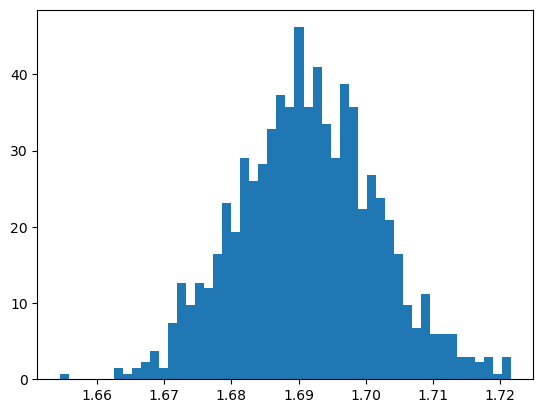

In [59]:
#Приведем распределение к нормальному
men_coupon_normal = []
for i in range (1000):
    men_coupon_normal.append(df3_male.sample (frac=10, replace = True).CouponUsed.mean())
plt.hist(men_coupon_normal,density = True, bins = 50)

In [60]:
#Проверим нормальное ли распределение у мужщин
stats.shapiro(men_coupon_normal)
Stat, p_value = stats.shapiro(men_coupon_normal)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

H0 не отвергаем, распределение - нормально


<function matplotlib.pyplot.show(close=None, block=None)>

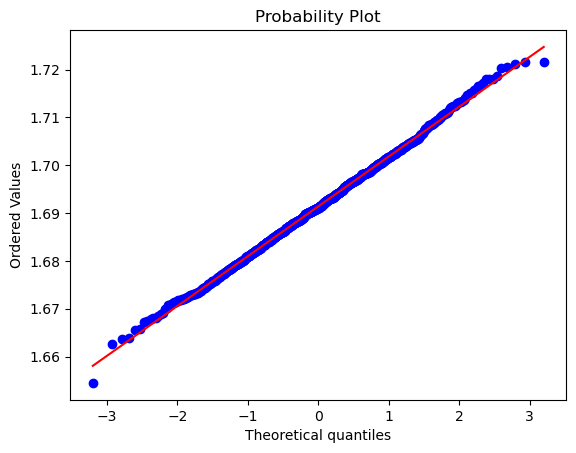

In [61]:
#Посмотрим на probability plot
stats.probplot(men_coupon_normal, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

In [62]:
#Проверим нормальное ли распределение у женщин
stats.shapiro(women_coupon)
Stat, p_value = stats.shapiro(women_coupon)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

Распределение не соответствует признакам нормальности


In [63]:
#Проверим нормальное ли распределение у женщин c помощью теста Колмогорова-Смирнова
stat, p_value = stats.kstest(women_coupon, 'norm')
alpha = 0.05
if p_value > alpha:
    print ('H0 не отвергаем, распределение - нормальное')
else:
    print('Распределение не соотвествует признакам нормальности')

Распределение не соотвествует признакам нормальности


(array([ 0.59590578,  1.19181155,  0.59590578,  0.59590578,  0.        ,
         2.97952888,  0.59590578,  4.76724621,  5.36315199,  8.93858665,
         7.15086932,  9.53449243, 11.32220976, 10.13039821, 10.72630398,
        14.89764442, 17.8771733 , 22.04851374, 21.45260796, 29.79528884,
        25.6239484 , 26.21985418, 25.02804262, 20.26079641, 33.96662928,
        28.60347729, 28.00757151, 24.43213685, 26.21985418, 28.60347729,
        25.6239484 , 21.45260796, 20.26079641, 14.30173864, 12.51402131,
         7.15086932,  9.53449243,  8.34268087,  7.7467751 ,  5.36315199,
         1.78771733,  4.76724621,  2.97952888,  1.19181155,  0.        ,
         1.19181155,  1.78771733,  0.59590578,  1.19181155,  0.59590578]),
 array([1.80009412, 1.80177224, 1.80345035, 1.80512847, 1.80680659,
        1.80848471, 1.81016282, 1.81184094, 1.81351906, 1.81519718,
        1.81687529, 1.81855341, 1.82023153, 1.82190965, 1.82358776,
        1.82526588, 1.826944  , 1.82862212, 1.83030024, 1.831978

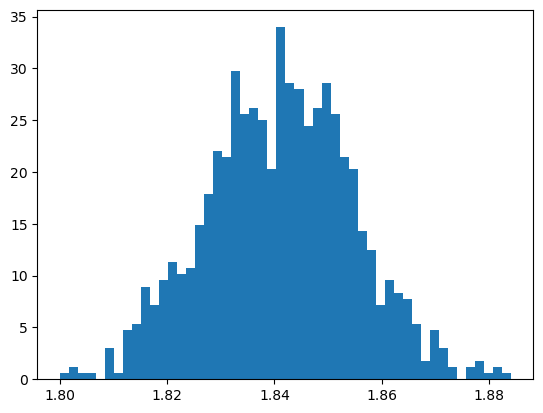

In [64]:
#Приведем распределение к нормальному
women_coupon_normal = []
for i in range (1000):
    women_coupon_normal.append(df3_female.sample (frac=10, replace = True).CouponUsed.mean())
plt.hist(women_coupon_normal,density = True, bins = 50)

In [65]:
#Проверим нормальное ли распределение у женщин
stats.shapiro(women_coupon_normal)
Stat, p_value = stats.shapiro(women_coupon_normal)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

H0 не отвергаем, распределение - нормально


<function matplotlib.pyplot.show(close=None, block=None)>

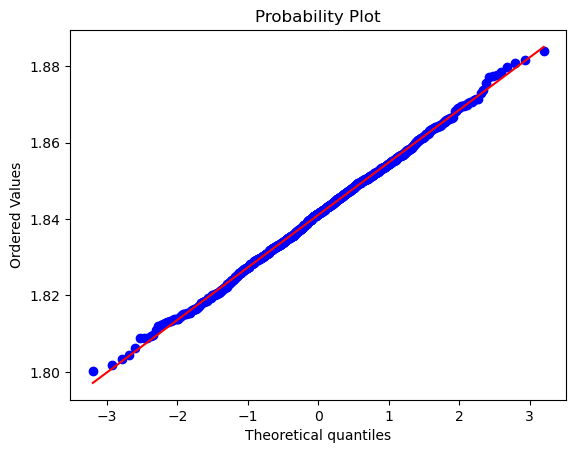

In [66]:
#Посмотрим на probability plot
stats.probplot(women_coupon_normal, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

In [67]:
#Теперь проверим нашу гипотезу, сформулируем ее
#H0 - пол не влияет на количество использованных купонов.
#H1 - пол влияет на количество использованных купонов.
#Будем использовать t-test, тк данные у нас выборочные
#Кроме нормальности проверим еще разные ли у нас дисперсии
var1 = df3_male.CouponUsed.var()
var2 = df3_female.CouponUsed.var()
print (var1, var2)

3.311760192980885 4.0026157084302145


In [68]:
#Теперь проверим нашу гипотезу, учитывая, что дисперсии разные, посчитаем степени свободы уэлча.
n1 = len(df3_male)
n2 = len(df3_female)
v1 = var1/n1
v2 = var2/n2
dofW = (v1+v2)**2/(v1**2/(n1-1)+v2**2/(n2-2))
print (dofW)

4232.337740002934


In [69]:
ttest = scipy.stats.ttest_ind(men_coupon_normal, women_coupon_normal, equal_var = False)
tstat = ttest [0]
t_crit = stats.t.ppf(0.95, dofW)
def hypothesis_chech(tstat, t_crit):
    if abs (tstat) > (t_crit):
        print('Отвергаем H0, пол влияет на количество использованных купонов.')
    else:
        print('Не отвергаем H0, пол не влияет на количество использованных купонов.')
hypothesis_chech(tstat,t_crit)

Отвергаем H0, пол влияет на количество использованных купонов.


Таким образом, пришли к выводу, что пол влияет на количество купонов, как и предполагали.

## Кешбеки

In [70]:
#Перейдем к изучения кешбека (CashbackAmount). 
#Сначала как обычно посмотрим на разные значения.
df['CashbackAmount'].describe()

count    5630.000000
mean      177.223030
std        49.207036
min         0.000000
25%       145.770000
50%       163.280000
75%       196.392500
max       324.990000
Name: CashbackAmount, dtype: float64

<Axes: >

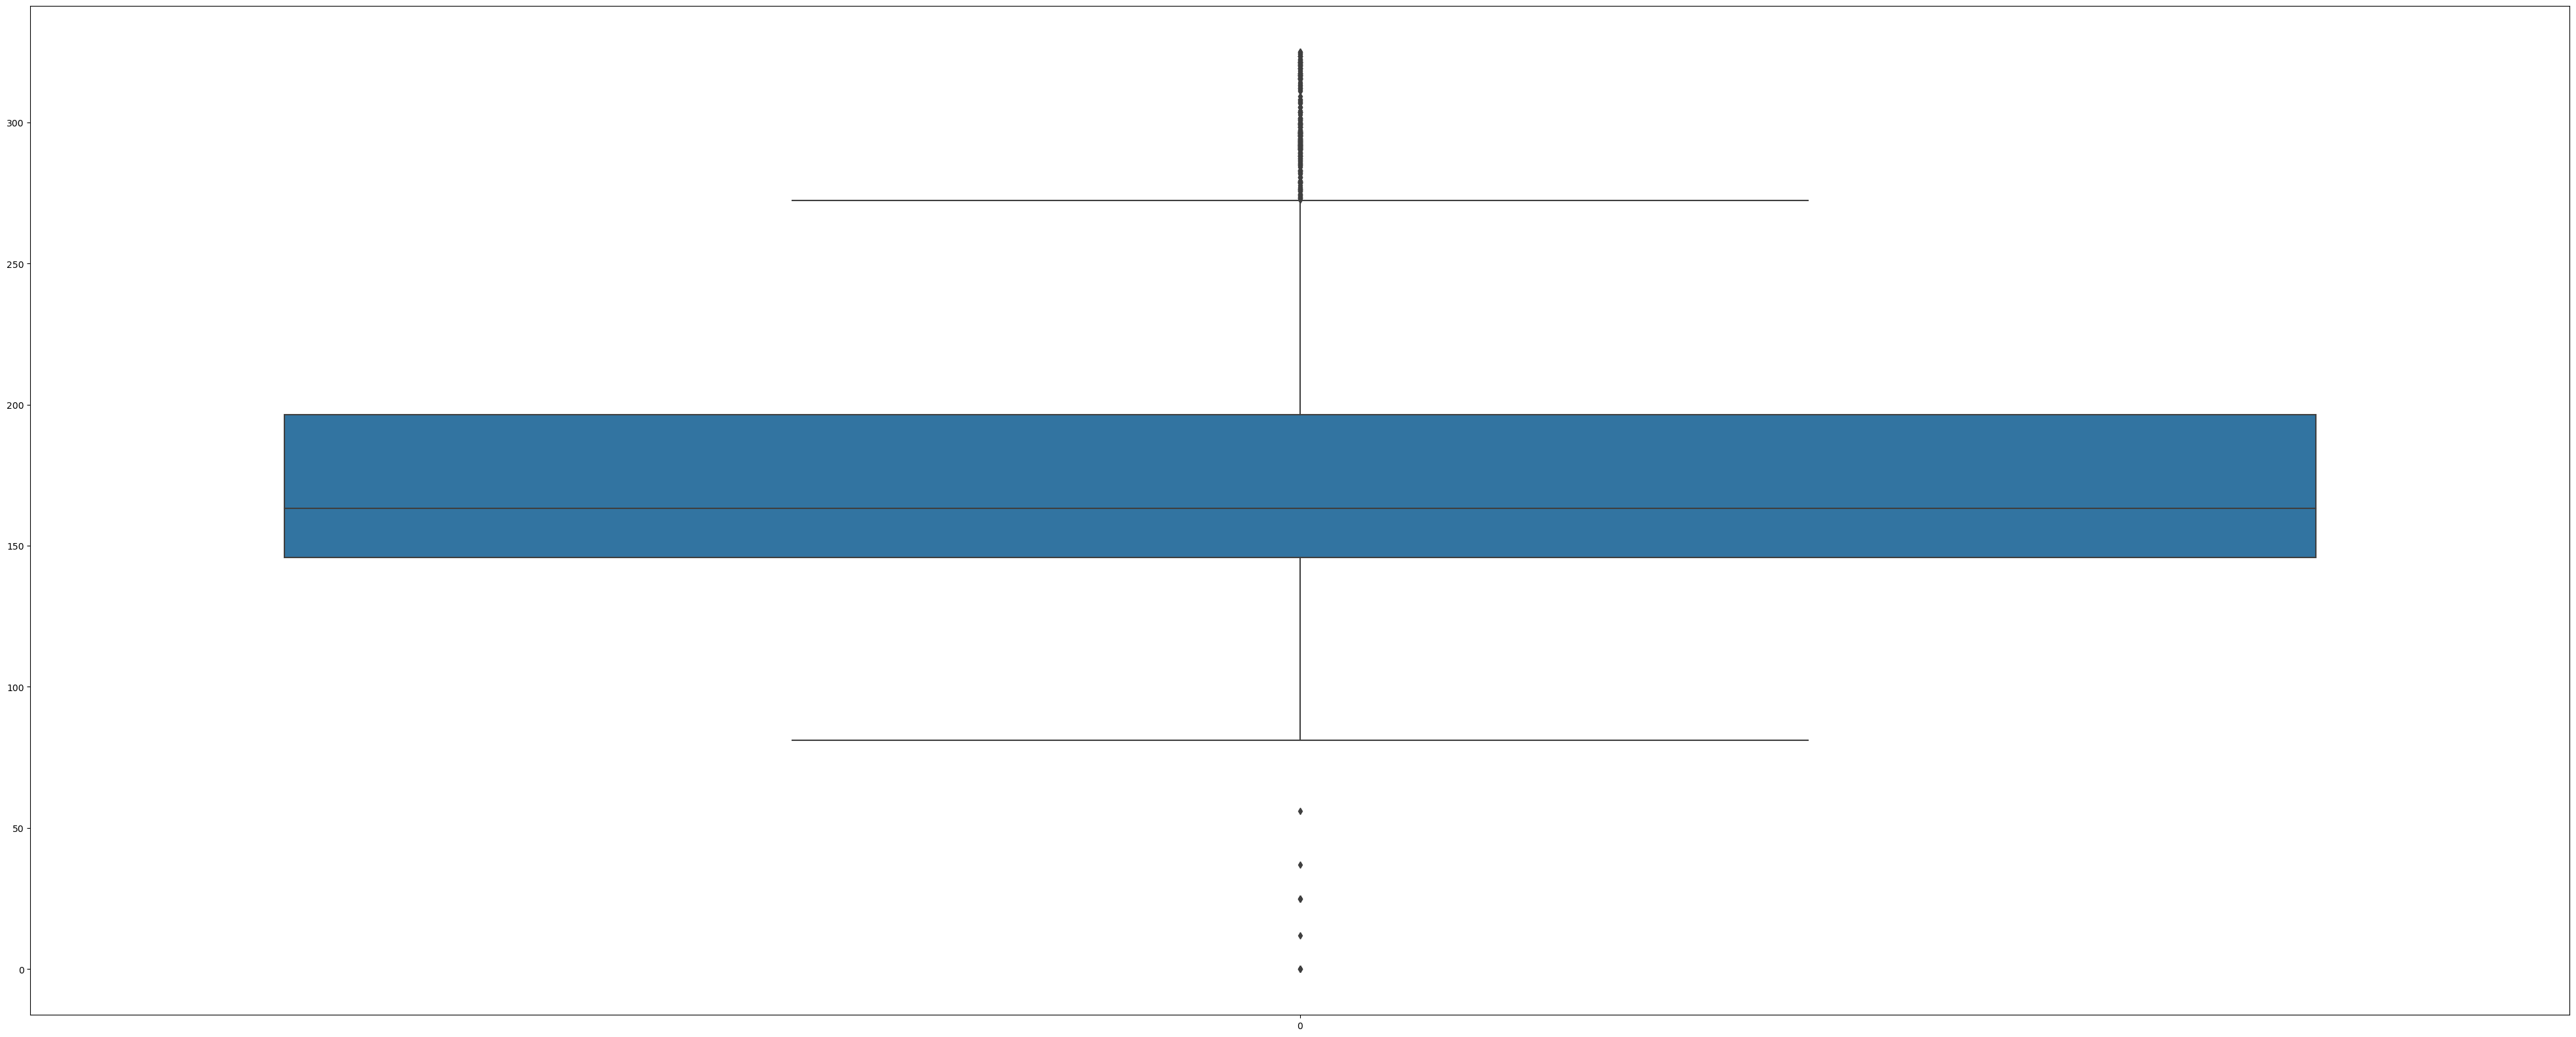

In [71]:
#Кажется у нас есть выбросы, посмотрим на ящик с усами
plt.figure(figsize = (50,20))
sns.boxplot(data=df['CashbackAmount'])

In [72]:
#Найдем z оценку, то есть на сколько стандартных отклонений отличаются значения
zscore = scipy.stats.zscore(df['CashbackAmount'])
zscore

0      -0.351465
1      -1.144715
2      -1.157316
3      -0.877047
4      -0.967895
          ...   
5625   -0.538854
5626    0.969195
5627    0.186920
5628    0.034083
5629   -0.166313
Name: CashbackAmount, Length: 5630, dtype: float64

In [73]:
#Уберем наши выбросы
df_trimmed = df[~(zscore.abs()>3)]
df_trimmed.shape

(5619, 23)

In [74]:
#Таким образом мы убрали 11 выбросов, так как раньше было 5630 значений, посмотрим на этих клеинтов.
vybrosi = df[~(zscore.abs()<3)]
vybrosi

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat,PreferredLoginDeviceTrue,PreferredPaymentModeTrue
101,50102,0,10.0,Computer,3,10.0,E wallet,Male,2.0,3,...,5,0,17.0,1.0,5.0,8.0,0.00,Клиент не удовлетворен,Computer,E wallet
1026,51027,0,1.0,Mobile Phone,1,33.0,Credit Card,Female,2.0,5,...,1,0,21.0,1.0,1.0,0.0,0.00,Клиент удовлетворен,Phone,Credit Card
1176,51177,0,30.0,Computer,3,8.0,Credit Card,Male,2.0,3,...,5,0,22.0,10.0,14.0,14.0,0.00,Клиент удовлетворен,Computer,Credit Card
1255,51256,0,8.0,Mobile Phone,3,24.0,Credit Card,Male,3.0,3,...,1,0,16.0,0.0,1.0,4.0,0.00,Клиент удовлетворен,Phone,Credit Card
1300,51301,0,6.0,Mobile Phone,1,21.0,Credit Card,Female,3.0,3,...,1,1,13.0,5.0,8.0,1.0,12.00,Клиент не удовлетворен,Phone,Credit Card
2880,52881,0,26.0,Mobile Phone,1,7.0,Debit Card,Male,4.0,5,...,2,0,15.0,2.0,12.0,10.0,324.99,Клиент не удовлетворен,Phone,Debit Card
2916,52917,0,11.0,Computer,3,11.0,E wallet,Male,3.0,4,...,6,0,18.0,2.0,6.0,9.0,25.00,Клиент не удовлетворен,Computer,E wallet
3841,53842,0,2.0,Mobile Phone,1,34.0,Credit Card,Female,3.0,6,...,2,0,22.0,2.0,2.0,1.0,25.00,Клиент удовлетворен,Phone,Credit Card
3991,53992,0,31.0,Computer,3,9.0,Credit Card,Male,3.0,4,...,6,0,23.0,11.0,15.0,15.0,25.00,Клиент удовлетворен,Computer,Credit Card
4070,54071,0,9.0,Mobile Phone,3,25.0,Credit Card,Male,4.0,4,...,2,0,17.0,1.0,2.0,5.0,25.00,Клиент удовлетворен,Phone,Credit Card


Видим, что эти клиенты либо не получили кешбека совсем, либо получили слишком большой кешбек.

In [75]:
#Посмотрим, как изменились наши значения.
df_trimmed['CashbackAmount'].describe()

count    5619.000000
mean      177.434362
std        48.729207
min        37.000000
25%       145.830000
50%       163.340000
75%       196.400000
max       324.730000
Name: CashbackAmount, dtype: float64

/Users/ekaterinaprozorova/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


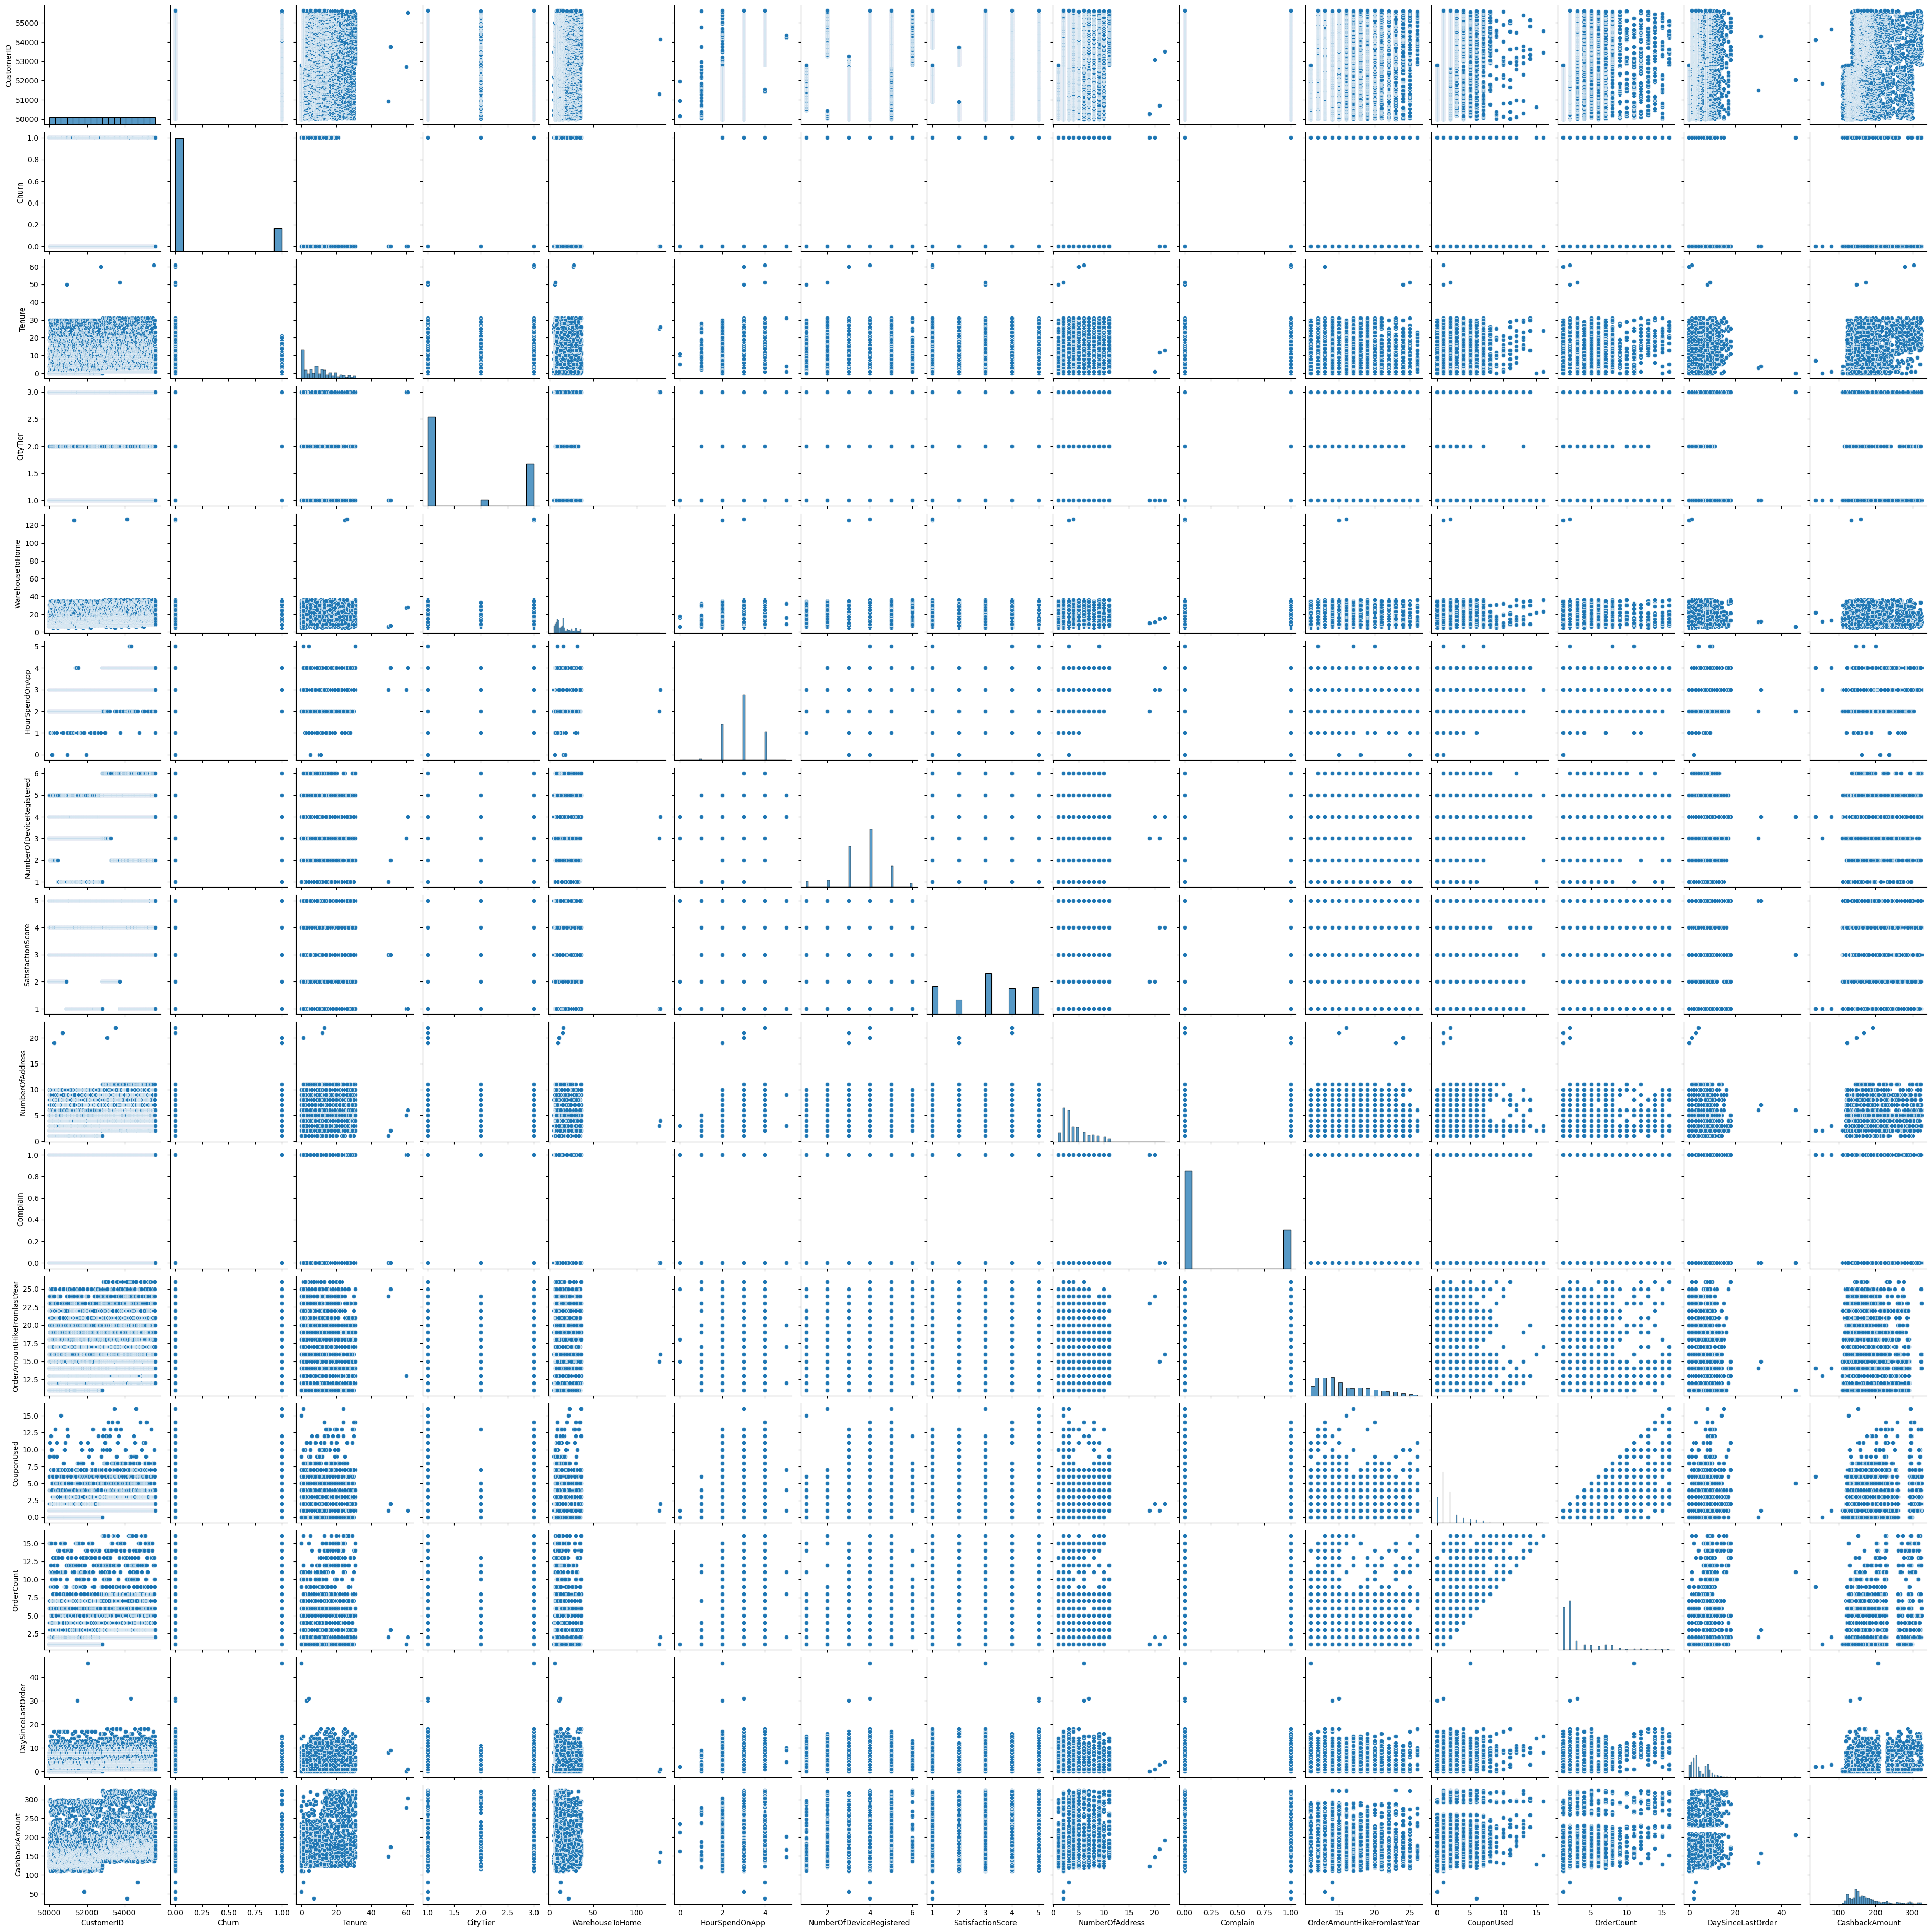

In [76]:
#Теперь выведем внутренних взаимосвязей между всеми парами переменных в наборе данных, хочется посомтреть на кешбек детальнее.
sns.pairplot(df_trimmed)

In [77]:
#Видим, что распределение кешбека напоминает нам отдаленно нормальное.
#Теперь поисследуем связана ли величина кешбека с оттоком. 
#Будем проверять эту гипотезу.
df_trimmed_churn = df_trimmed[df_trimmed['Churn']==1]
df_trimmed_nonchurn = df_trimmed[df_trimmed['Churn']==0]
df_trimmed_churn_cashback = df_trimmed_churn['CashbackAmount']
df_trimmed_nonchurn_cashback = df_trimmed_nonchurn['CashbackAmount']
print (df_trimmed_churn_cashback.mean(), df_trimmed_nonchurn_cashback.mean())

160.3709282700422 180.89746092913722


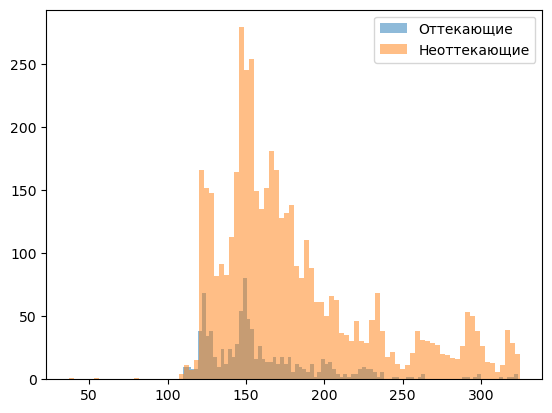

In [78]:
#Посмотрим, как распределен кешбек у оттекающих и неоттекающих.
plt.hist(df_trimmed_churn_cashback, label = 'Оттекающие', bins = 90, alpha = 0.5)
plt.hist(df_trimmed_nonchurn_cashback, label = 'Неоттекающие', bins = 90, alpha = 0.5)
plt.legend()
plt.show()

In [79]:
#Проверим нормальное ли распределение у оттекающих c помощью теста Шапира Уилка
stats.shapiro(df_trimmed_churn_cashback)
Stat, p_value = stats.shapiro(df_trimmed_churn_cashback)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

Распределение не соответствует признакам нормальности


In [80]:
#Проверим нормальное ли распределение у оттекающих c помощью теста Колмогорова-Смирнова
stat, p_value = stats.kstest(df_trimmed_churn_cashback, 'norm')
alpha = 0.05
if p_value > alpha:
    print ('H0 не отвергаем, распределение - нормальное')
else:
    print('Распределение не соотвествует признакам нормальности')

Распределение не соотвествует признакам нормальности


<function matplotlib.pyplot.show(close=None, block=None)>

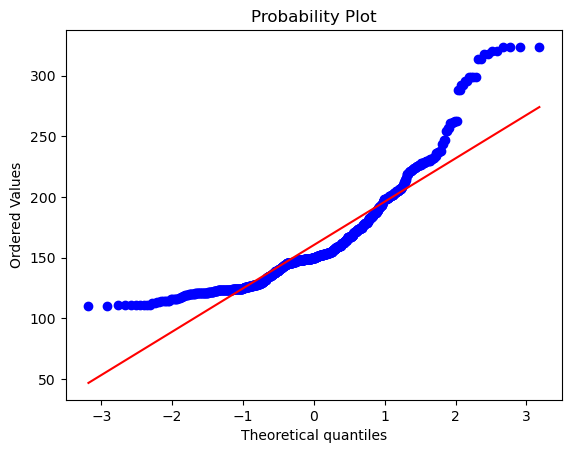

In [81]:
#Посмотрим на probability plot
stats.probplot(df_trimmed_churn_cashback, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

(array([ 0.59590578,  1.19181155,  0.59590578,  0.59590578,  0.        ,
         2.97952888,  0.59590578,  4.76724621,  5.36315199,  8.93858665,
         7.15086932,  9.53449243, 11.32220976, 10.13039821, 10.72630398,
        14.89764442, 17.8771733 , 22.04851374, 21.45260796, 29.79528884,
        25.6239484 , 26.21985418, 25.02804262, 20.26079641, 33.96662928,
        28.60347729, 28.00757151, 24.43213685, 26.21985418, 28.60347729,
        25.6239484 , 21.45260796, 20.26079641, 14.30173864, 12.51402131,
         7.15086932,  9.53449243,  8.34268087,  7.7467751 ,  5.36315199,
         1.78771733,  4.76724621,  2.97952888,  1.19181155,  0.        ,
         1.19181155,  1.78771733,  0.59590578,  1.19181155,  0.59590578]),
 array([1.80009412, 1.80177224, 1.80345035, 1.80512847, 1.80680659,
        1.80848471, 1.81016282, 1.81184094, 1.81351906, 1.81519718,
        1.81687529, 1.81855341, 1.82023153, 1.82190965, 1.82358776,
        1.82526588, 1.826944  , 1.82862212, 1.83030024, 1.831978

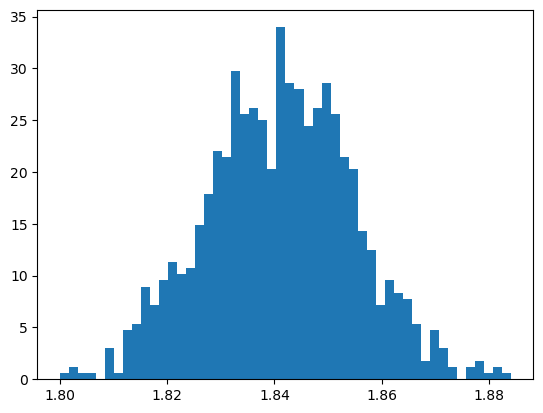

In [82]:
#Приведем распределение к нормальному
df_trimmed_churn_cashback_normal = []
for i in range (1000):
    df_trimmed_churn_cashback_normal.append(df_trimmed_churn.sample (frac=10, replace = True).CashbackAmount.mean())
plt.hist(women_coupon_normal,density = True, bins = 50)

<function matplotlib.pyplot.show(close=None, block=None)>

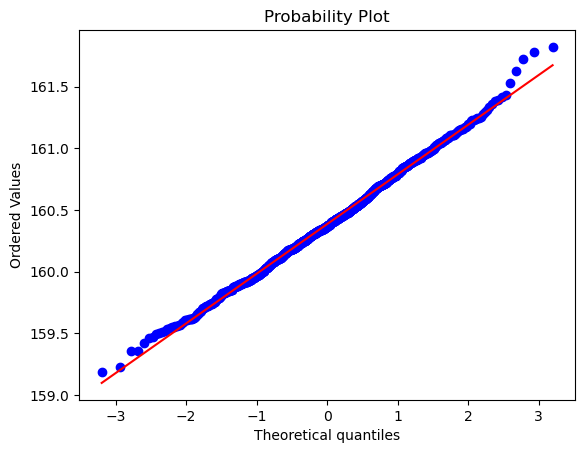

In [83]:
#Посмотрим еще раз на probability plot
stats.probplot(df_trimmed_churn_cashback_normal, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

In [84]:
#Проверим нормальное ли распределение теперь
stats.shapiro(df_trimmed_churn_cashback_normal)
Stat, p_value = stats.shapiro(df_trimmed_churn_cashback_normal)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

H0 не отвергаем, распределение - нормально


In [85]:
#Проверим нормальное ли распределение у неоттекающих c помощью теста Шапира Уилка
stats.shapiro(df_trimmed_nonchurn_cashback)
Stat, p_value = stats.shapiro(df_trimmed_nonchurn_cashback)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

Распределение не соответствует признакам нормальности


In [86]:
#Проверим нормальное ли распределение у оттекающих c помощью теста Колмогорова-Смирнова
stat, p_value = stats.kstest(df_trimmed_nonchurn_cashback, 'norm')
alpha = 0.05
if p_value > alpha:
    print ('H0 не отвергаем, распределение - нормальное')
else:
    print('Распределение не соотвествует признакам нормальности')

Распределение не соотвествует признакам нормальности


<function matplotlib.pyplot.show(close=None, block=None)>

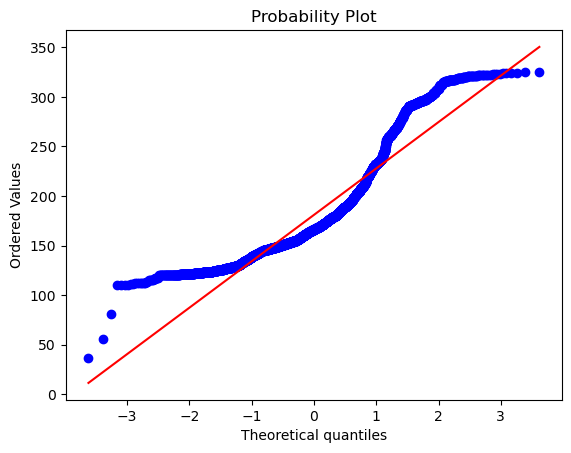

In [87]:
#Посмотрим на probability plot
stats.probplot(df_trimmed_nonchurn_cashback, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

(array([ 0.59590578,  1.19181155,  0.59590578,  0.59590578,  0.        ,
         2.97952888,  0.59590578,  4.76724621,  5.36315199,  8.93858665,
         7.15086932,  9.53449243, 11.32220976, 10.13039821, 10.72630398,
        14.89764442, 17.8771733 , 22.04851374, 21.45260796, 29.79528884,
        25.6239484 , 26.21985418, 25.02804262, 20.26079641, 33.96662928,
        28.60347729, 28.00757151, 24.43213685, 26.21985418, 28.60347729,
        25.6239484 , 21.45260796, 20.26079641, 14.30173864, 12.51402131,
         7.15086932,  9.53449243,  8.34268087,  7.7467751 ,  5.36315199,
         1.78771733,  4.76724621,  2.97952888,  1.19181155,  0.        ,
         1.19181155,  1.78771733,  0.59590578,  1.19181155,  0.59590578]),
 array([1.80009412, 1.80177224, 1.80345035, 1.80512847, 1.80680659,
        1.80848471, 1.81016282, 1.81184094, 1.81351906, 1.81519718,
        1.81687529, 1.81855341, 1.82023153, 1.82190965, 1.82358776,
        1.82526588, 1.826944  , 1.82862212, 1.83030024, 1.831978

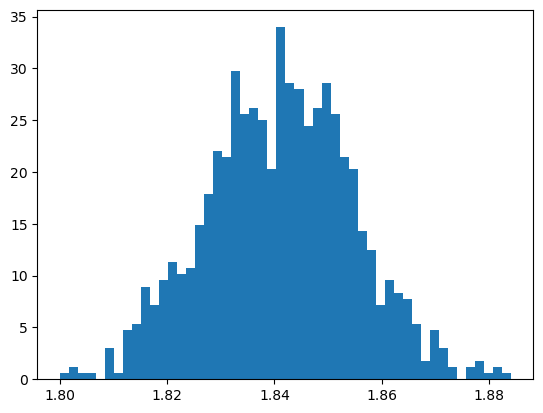

In [88]:
#Приведем распределение к нормальному
df_trimmed_nonchurn_cashback_normal = []
for i in range (1000):
    df_trimmed_nonchurn_cashback_normal.append(df_trimmed_nonchurn.sample (frac=10, replace = True).CashbackAmount.mean())
plt.hist(women_coupon_normal,density = True, bins = 50)

In [89]:
#Проверим нормальное ли распределение теперь
stats.shapiro(df_trimmed_nonchurn_cashback_normal)
Stat, p_value = stats.shapiro(df_trimmed_nonchurn_cashback_normal)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

H0 не отвергаем, распределение - нормально


<function matplotlib.pyplot.show(close=None, block=None)>

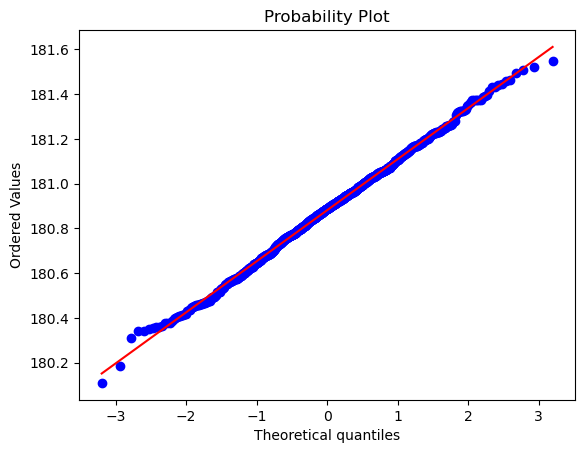

In [90]:
#Посмотрим еще раз на probability plot
stats.probplot(df_trimmed_nonchurn_cashback_normal, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

In [91]:
#Теперь проверим нашу гипотезу, сформулируем ее
#H0 - Нет зависимости между оттоком и кешбеком.
#H1 - Есть зависимость между оттоком и кешбеком.
#Будем использовать t-test, тк данные у нас выборочные
#Кроме нормальности проверим еще разные ли у нас дисперсии
var1 = df_trimmed_churn.CashbackAmount.var()
var2 = df_trimmed_nonchurn.CashbackAmount.var()
print (var1, var2)

1477.3303222630643 2485.8820514532317


In [92]:
#Теперь проверим нашу гипотезу, учитывая, что дисперсии разные, посчитаем степени свободы Уэлча.
n1 = len(df_trimmed_churn)
n2 = len(df_trimmed_nonchurn)
v1 = var1/n1
v2 = var2/n2
dofW = (v1+v2)**2/(v1**2/(n1-1)+v2**2/(n2-2))
print (dofW)

1664.8803072921623


In [93]:
ttest = scipy.stats.ttest_ind(df_trimmed_churn_cashback_normal, df_trimmed_nonchurn_cashback_normal, equal_var = False)
tstat = ttest [0]
t_crit = stats.t.ppf(0.95, dofW)
def hypothesis_chech(tstat, t_crit):
    if abs (tstat) > (t_crit):
        print('Отвергаем H0, есть зависимость между оттоком и кешбеком.')
    else:
        print('Не отвергаем H0, нет зависимости между оттоком и кешбеком.')
hypothesis_chech(tstat,t_crit)

Отвергаем H0, есть зависимость между оттоком и кешбеком.


Таким образом мы видим, что есть зависимость полученного кешбека и флага оттока.

In [94]:
#Можем еще посмотреть коэффициент корреляции кешбека от уровня жизни клиента в организации.
#Для этого уберем пропуски в 'Tenure'.
df_trimmed2 = df_trimmed.dropna(subset=['OrderCount'])
df_trimmed2['CashbackAmount'].corr(df_trimmed2['Tenure'])

0.46520905804005847

<Axes: xlabel='Tenure', ylabel='CashbackAmount'>

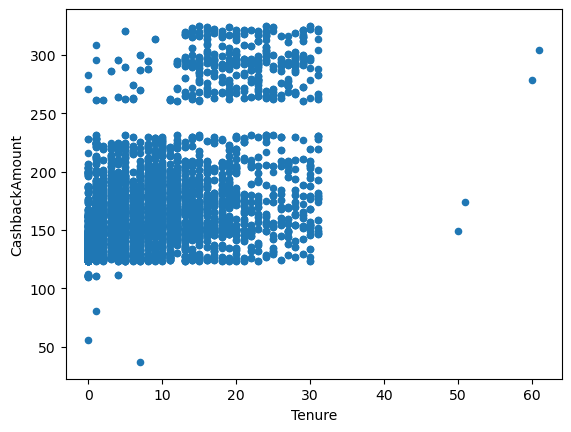

In [95]:
df_trimmed2.plot('Tenure','CashbackAmount', kind = 'scatter')

График получился не показательный, мы такой уже выводили когда смотрели на sns.pairplot. Но по шкале Чеддока это умеренная корреляция, поэтому можем принять, что чем дольше клиент живет в орагнизации, тем больше кешбека он получает.

## Расстояние и заказы:

Исследовать расстояние от склада до дома (WarehouseToHome), убрать выбросы, посмотреть корреляцию с количеством заказов.
Исследовать, как тип города (CityTier) влияет расстояние от склада до дома (WarehouseToHome).

In [96]:
#Теперь посмотрим на перемнную расстония от склада до дома
#Опять же помним, что в ней есть пропуски и сразу их убираем
df5 = df.dropna(subset=['WarehouseToHome'])
df5.shape

(5379, 23)

In [97]:
#Посмотрим на основные показатели
df5['WarehouseToHome'].describe()

count    5379.000000
mean       15.639896
std         8.531475
min         5.000000
25%         9.000000
50%        14.000000
75%        20.000000
max       127.000000
Name: WarehouseToHome, dtype: float64

<Axes: >

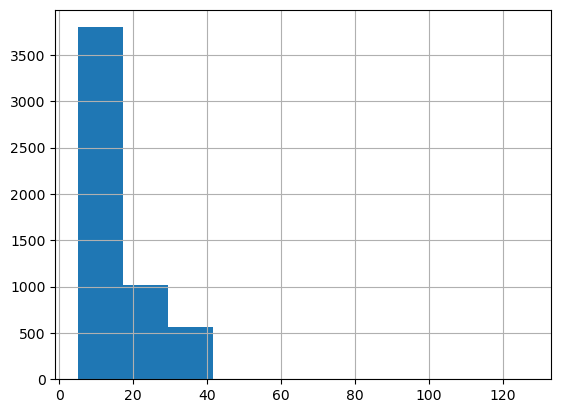

In [98]:
df5['WarehouseToHome'].hist()

<Axes: >

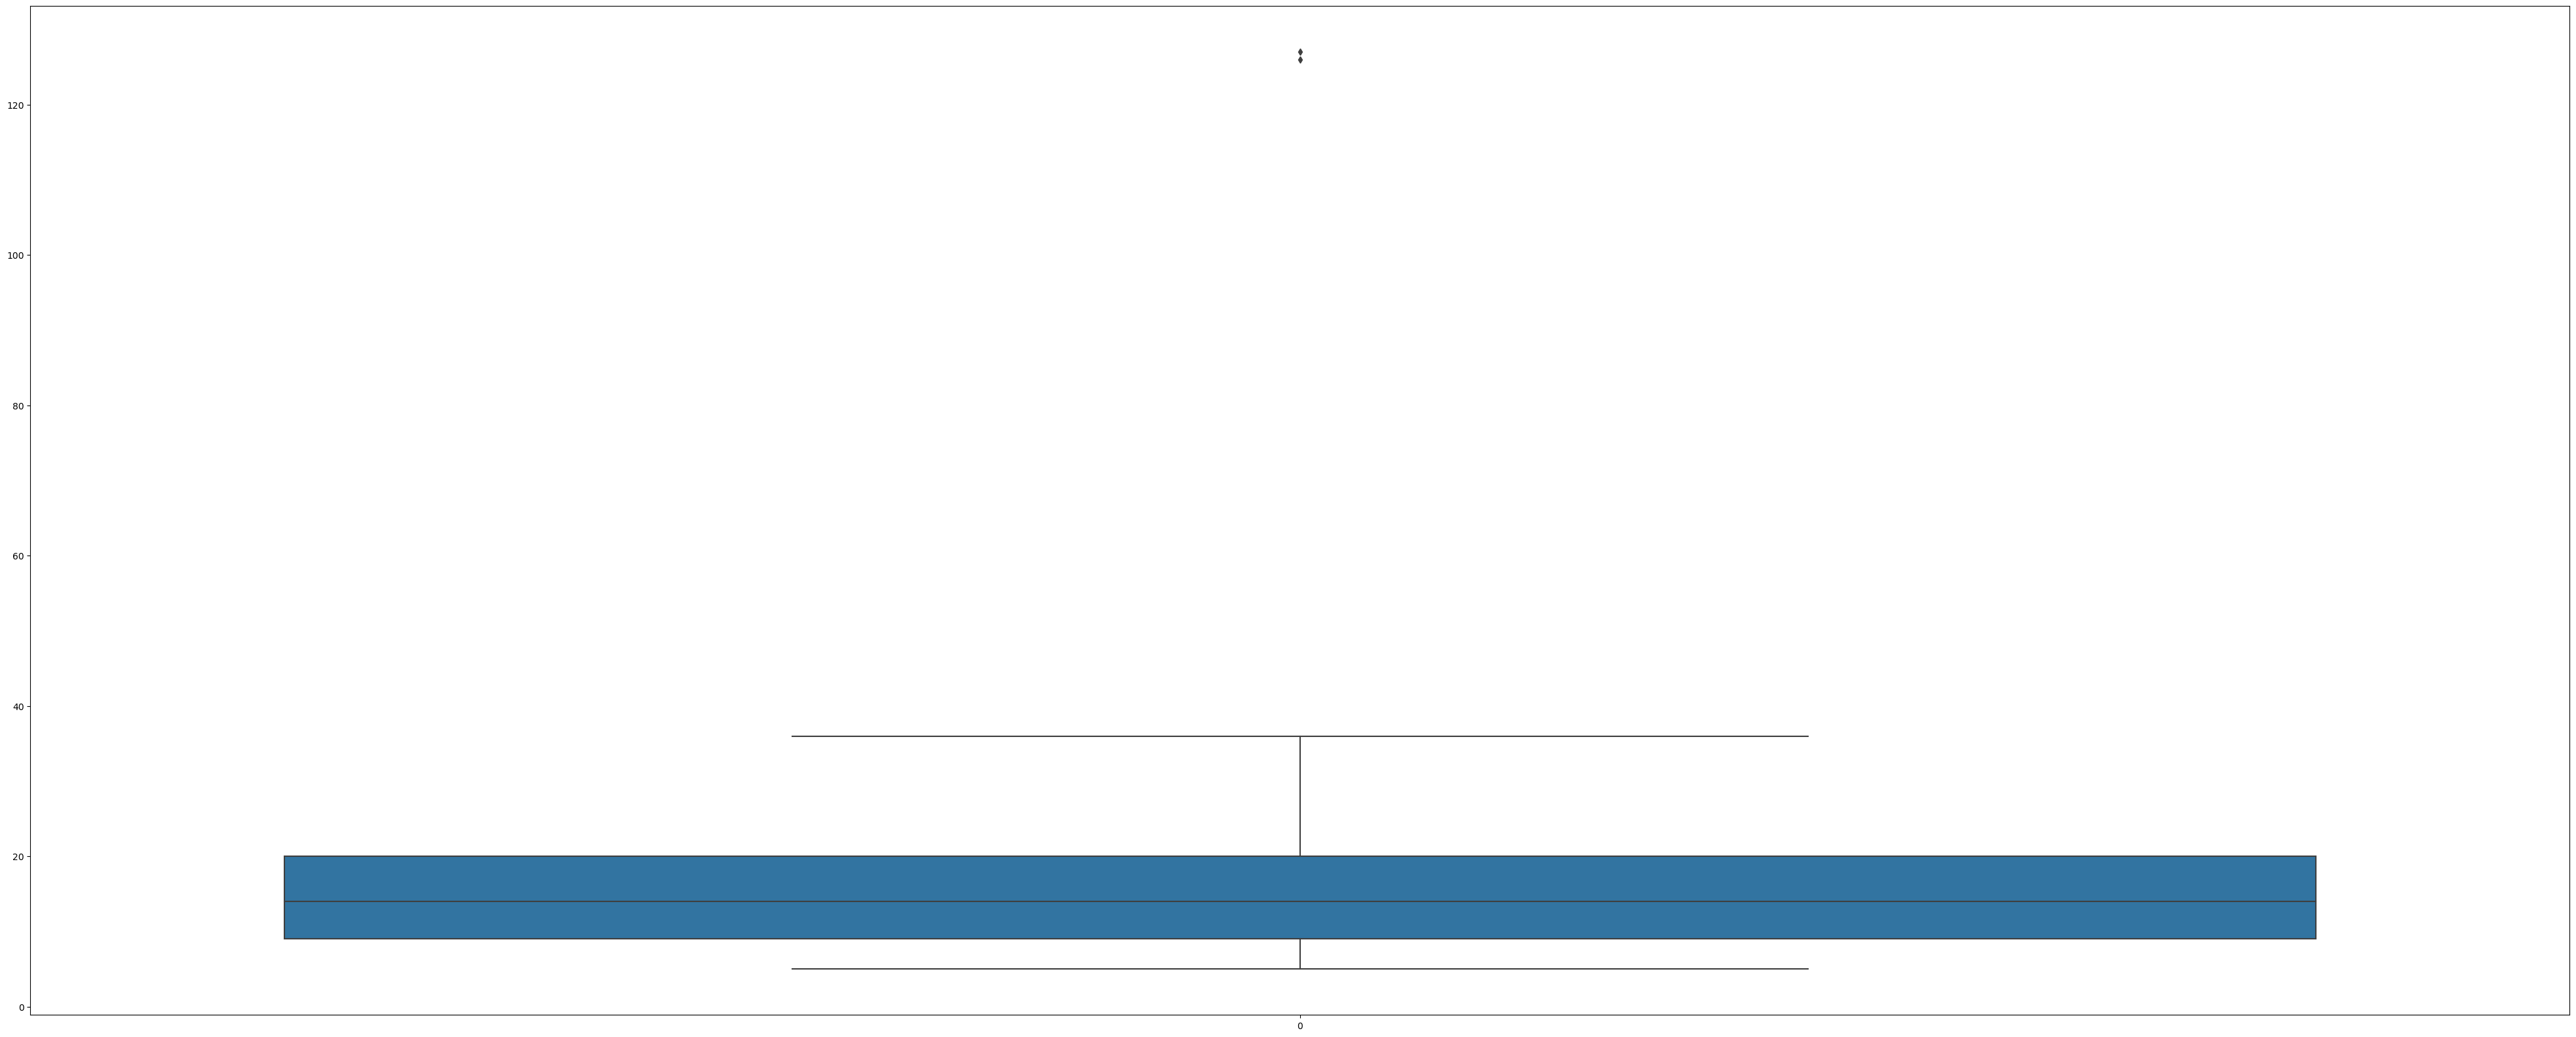

In [99]:
plt.figure(figsize = (50,20))
sns.boxplot(data=df5['WarehouseToHome'])

In [100]:
#У нас явно есть выбросы, давайте их уберем с помощью z-оценки
zscore = scipy.stats.zscore(df5['WarehouseToHome'])
zscore

0      -1.130026
1      -0.895579
2       1.683348
3      -0.075011
4      -0.426683
          ...   
5625    1.683348
5626   -0.309459
5627   -0.543907
5628   -0.778355
5629   -0.075011
Name: WarehouseToHome, Length: 5379, dtype: float64

In [101]:
#Уберем наши выбросы
df5_trimmed = df5[~(zscore.abs()>3)]
df5_trimmed.shape

(5377, 23)

In [102]:
#Таким образом мы убрали 2 выброса, так как раньше было 5379 значений, посмотрим на этих клеинтов.
vybrosi = df5[~(zscore.abs()<3)]
vybrosi

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Satisfaction_cat,PreferredLoginDeviceTrue,PreferredPaymentModeTrue
1309,51310,0,25.0,Computer,3,126.0,Debit Card,Male,2.0,3,...,3,0,15.0,1.0,1.0,0.0,134.82,Клиент не удовлетворен,Computer,Debit Card
4124,54125,0,26.0,Computer,3,127.0,Debit Card,Male,3.0,4,...,4,0,16.0,2.0,2.0,1.0,159.82,Клиент не удовлетворен,Computer,Debit Card


Видим, что у этих клиентов расстояние от склада до дома 126 и 127 условных единиц, что сильно больше, чем у других клиентов.

In [103]:
#Посмотрим как расстояние от склада до дома коррелирует с количеством заказов.
#Преполагаем, что чем дальше склад, тем меньше заказов.
#Для этого выкинем из df5 пропуски в OrderCount.
df6 = df5.dropna(subset=['OrderCount'])
df6.shape

(5121, 23)

In [104]:
df6['WarehouseToHome'].corr(df6['OrderCount'])

0.002680877977218745

Видим, что корреляции у нас нет, поэтому нет зависмости между количеством заказов и расстоянием от дома до склада.

In [105]:
#Теперь поисследуем, как тип города (CityTier)
#Какие у нас вообще бывают тиры?
df['CityTier'].unique()

array([3, 1, 2])

In [106]:
#Получается бывает всего 3 типа городов, давайте посмотрим на значения описательной статистики по ним.
#Будем брать данные по WarehouseToHome, OrderCount, DaySinceLastOrder, Tenure, CashbackAmount
#Будем брать данные без пропусков. 
df7=df.dropna(subset=['WarehouseToHome', 'OrderCount', 'DaySinceLastOrder', 'Tenure'])
#Построим сводную таблицу
df.pivot_table(index = ['CityTier'],
              values = ['WarehouseToHome', 'OrderCount', 'DaySinceLastOrder', 'Tenure', 'CashbackAmount'],
              aggfunc = ['mean', 'median', len])

mean                                          \
         CashbackAmount DaySinceLastOrder OrderCount     Tenure   
CityTier                                                          
1            175.282079          4.514416   2.953255  10.528818   
2            177.622810          4.089744   2.584034  11.169725   
3            181.298978          4.674653   3.185185   9.361740   

                                 median                                      \
         WarehouseToHome CashbackAmount DaySinceLastOrder OrderCount Tenure   
CityTier                                                                      
1              15.597399        157.945               3.0        2.0    9.0   
2              14.978632        154.490               3.0        2.0   11.0   
3              15.818991        173.500               3.0        2.0    8.0   

                                    len                                      \
         WarehouseToHome CashbackAmount DaySinceLastOrder OrderCount Tenure   
CityTier                                                                      
1                   13.0           3666              3666       3666   3666   
2                   13.0            242               242        242    242   
3                   14.0           1722              1722       1722   1722   

                          
         WarehouseToHome  
CityTier                  
1                   3666  
2                    242  
3                   1722

In [107]:
#Теперь посмотрим как тип города (CityTier) влияет расстояние от склада до дома (WarehouseToHome). 
#Допустим у нас есть люди живушие в больших городах (Тир 1) и городах поменьше (Тир 2 или 3).
#Преположим, что среднее расстояние от склада до дома будут различны в этих группах.
#Возьмем выборку без выбросов df5_trimmed
df5_trimmed_tier1 = df5_trimmed[df5_trimmed['CityTier']==1]
df5_trimmed_tier23 = df5_trimmed[df5_trimmed['CityTier'].isin([2, 3])]
df5_trimmed_tier1_warehouse = df5_trimmed_tier1['WarehouseToHome']
df5_trimmed_tier23_warehouse = df5_trimmed_tier23['WarehouseToHome']
print (df5_trimmed_tier1_warehouse.mean(), df5_trimmed_tier23_warehouse.mean())

15.597398843930636 15.60093896713615


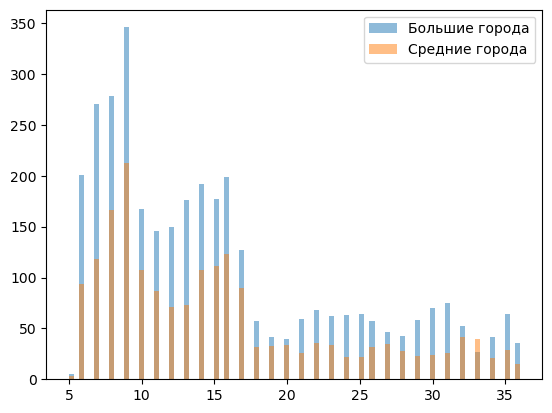

In [108]:
#Посмотрим, как распределено расстояние у жителей больших и средних городов.
plt.hist(df5_trimmed_tier1_warehouse, label = 'Большие города', bins = 90, alpha = 0.5)
plt.hist(df5_trimmed_tier23_warehouse, label = 'Средние города', bins = 90, alpha = 0.5)
plt.legend()
plt.show()

In [109]:
#Проверим нормальное ли распределение у жителей больших городов c помощью теста Шапира Уилка
stats.shapiro(df5_trimmed_tier1_warehouse)
Stat, p_value = stats.shapiro(df5_trimmed_tier1_warehouse)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

Распределение не соответствует признакам нормальности


In [110]:
#Проверим нормальное ли распределение у оттекающих c помощью теста Колмогорова-Смирнова
stat, p_value = stats.kstest(df5_trimmed_tier1_warehouse, 'norm')
alpha = 0.05
if p_value > alpha:
    print ('H0 не отвергаем, распределение - нормальное')
else:
    print('Распределение не соотвествует признакам нормальности')

Распределение не соотвествует признакам нормальности


<function matplotlib.pyplot.show(close=None, block=None)>

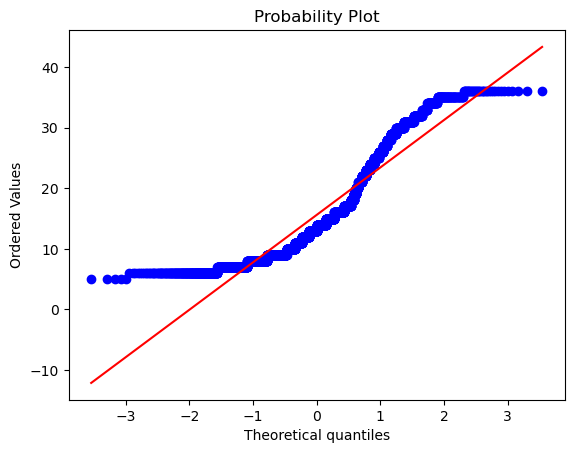

In [111]:
#Посмотрим на probability plot
stats.probplot(df5_trimmed_tier1_warehouse, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

(array([ 0.59590578,  1.19181155,  0.59590578,  0.59590578,  0.        ,
         2.97952888,  0.59590578,  4.76724621,  5.36315199,  8.93858665,
         7.15086932,  9.53449243, 11.32220976, 10.13039821, 10.72630398,
        14.89764442, 17.8771733 , 22.04851374, 21.45260796, 29.79528884,
        25.6239484 , 26.21985418, 25.02804262, 20.26079641, 33.96662928,
        28.60347729, 28.00757151, 24.43213685, 26.21985418, 28.60347729,
        25.6239484 , 21.45260796, 20.26079641, 14.30173864, 12.51402131,
         7.15086932,  9.53449243,  8.34268087,  7.7467751 ,  5.36315199,
         1.78771733,  4.76724621,  2.97952888,  1.19181155,  0.        ,
         1.19181155,  1.78771733,  0.59590578,  1.19181155,  0.59590578]),
 array([1.80009412, 1.80177224, 1.80345035, 1.80512847, 1.80680659,
        1.80848471, 1.81016282, 1.81184094, 1.81351906, 1.81519718,
        1.81687529, 1.81855341, 1.82023153, 1.82190965, 1.82358776,
        1.82526588, 1.826944  , 1.82862212, 1.83030024, 1.831978

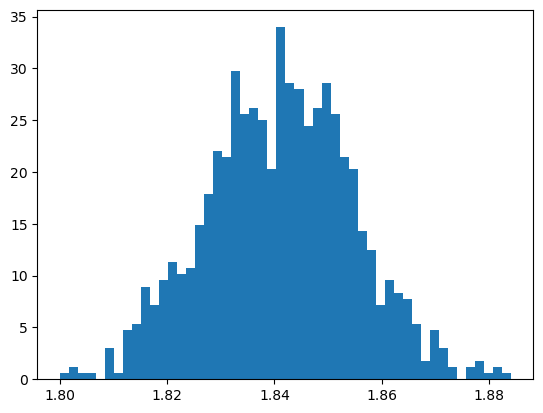

In [112]:
#Приведем распределение к нормальному
df5_trimmed_tier1_warehouse_normal = []
for i in range (1000):
    df5_trimmed_tier1_warehouse_normal.append(df5_trimmed_tier1.sample (frac=10, replace = True).WarehouseToHome.mean())
plt.hist(women_coupon_normal,density = True, bins = 50)

In [113]:
#Проверим нормальное ли распределение теперь
stats.shapiro(df5_trimmed_tier1_warehouse_normal)
Stat, p_value = stats.shapiro(df5_trimmed_tier1_warehouse_normal)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

H0 не отвергаем, распределение - нормально


<function matplotlib.pyplot.show(close=None, block=None)>

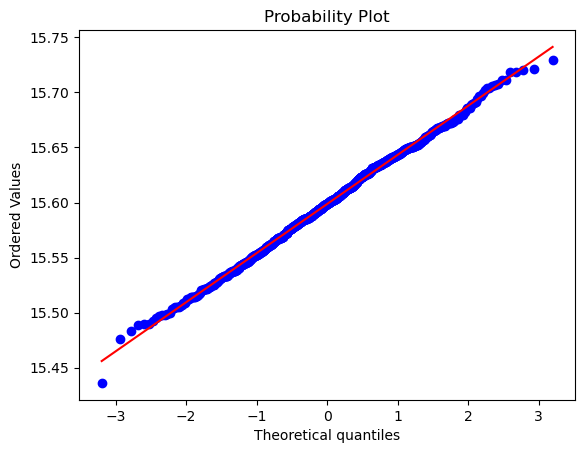

In [114]:
#Посмотрим еще раз на probability plot
stats.probplot(df5_trimmed_tier1_warehouse_normal, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

In [115]:
#Проверим нормальное ли распределение у жителей средних городов c помощью теста Шапира Уилка
stats.shapiro(df5_trimmed_tier23_warehouse)
Stat, p_value = stats.shapiro(df5_trimmed_tier23_warehouse)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

Распределение не соответствует признакам нормальности


In [116]:
#Проверим нормальное ли распределение у оттекающих c помощью теста Колмогорова-Смирнова
stat, p_value = stats.kstest(df5_trimmed_tier23_warehouse, 'norm')
alpha = 0.05
if p_value > alpha:
    print ('H0 не отвергаем, распределение - нормальное')
else:
    print('Распределение не соотвествует признакам нормальности')

Распределение не соотвествует признакам нормальности


<function matplotlib.pyplot.show(close=None, block=None)>

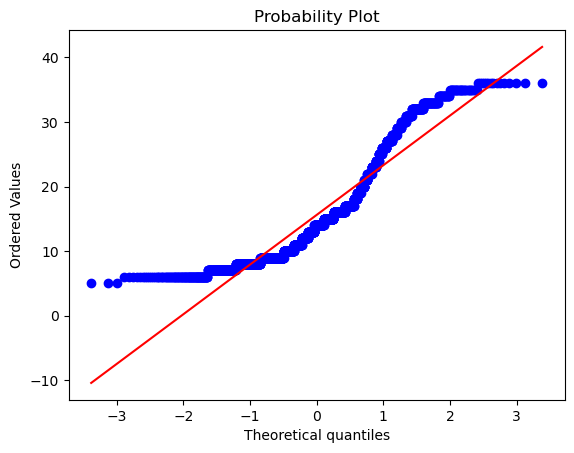

In [117]:
#Посмотрим на probability plot
stats.probplot(df5_trimmed_tier23_warehouse, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

(array([ 0.59590578,  1.19181155,  0.59590578,  0.59590578,  0.        ,
         2.97952888,  0.59590578,  4.76724621,  5.36315199,  8.93858665,
         7.15086932,  9.53449243, 11.32220976, 10.13039821, 10.72630398,
        14.89764442, 17.8771733 , 22.04851374, 21.45260796, 29.79528884,
        25.6239484 , 26.21985418, 25.02804262, 20.26079641, 33.96662928,
        28.60347729, 28.00757151, 24.43213685, 26.21985418, 28.60347729,
        25.6239484 , 21.45260796, 20.26079641, 14.30173864, 12.51402131,
         7.15086932,  9.53449243,  8.34268087,  7.7467751 ,  5.36315199,
         1.78771733,  4.76724621,  2.97952888,  1.19181155,  0.        ,
         1.19181155,  1.78771733,  0.59590578,  1.19181155,  0.59590578]),
 array([1.80009412, 1.80177224, 1.80345035, 1.80512847, 1.80680659,
        1.80848471, 1.81016282, 1.81184094, 1.81351906, 1.81519718,
        1.81687529, 1.81855341, 1.82023153, 1.82190965, 1.82358776,
        1.82526588, 1.826944  , 1.82862212, 1.83030024, 1.831978

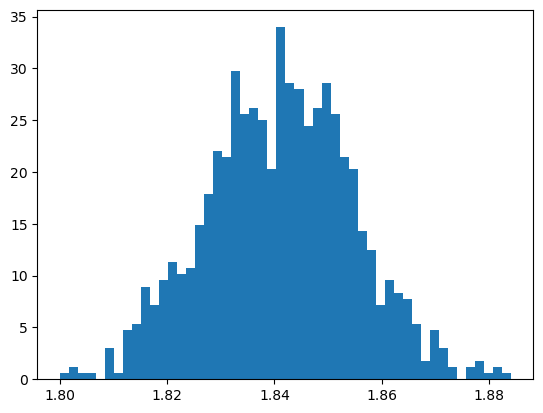

In [118]:
#Приведем распределение к нормальному
df5_trimmed_tier23_warehouse_normal = []
for i in range (1000):
    df5_trimmed_tier23_warehouse_normal.append(df5_trimmed_tier23.sample (frac=10, replace = True).WarehouseToHome.mean())
plt.hist(women_coupon_normal,density = True, bins = 50)

In [119]:
#Проверим нормальное ли распределение теперь
stats.shapiro(df5_trimmed_tier23_warehouse_normal)
Stat, p_value = stats.shapiro(df5_trimmed_tier23_warehouse_normal)
alpha = 0.05
if p_value > alpha:
    print('H0 не отвергаем, распределение - нормально')
else:
    print('Распределение не соответствует признакам нормальности')

H0 не отвергаем, распределение - нормально


<function matplotlib.pyplot.show(close=None, block=None)>

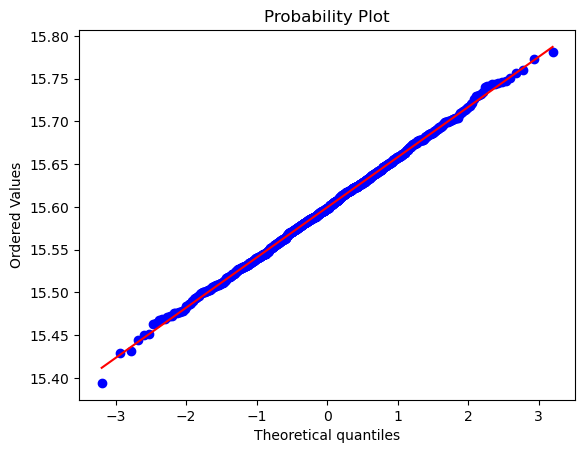

In [120]:
#Посмотрим на probability plot
stats.probplot(df5_trimmed_tier23_warehouse_normal, dist = 'norm', plot = pylab) 
#красная линия - форма распределения наших данных
pylab.show

In [121]:
#Теперь проверим нашу гипотезу, сформулируем ее
#H0 - Нет зависимости между размером города и расстоянием от дома до склада.
#H1 - Есть зависимость между размером города и расстоянием от дома до склада.
#Будем использовать t-test, тк данные у нас выборочные
#Кроме нормальности проверим еще разные ли у нас дисперсии
var1 = df5_trimmed_tier1.WarehouseToHome.var()
var2 = df5_trimmed_tier23.WarehouseToHome.var()
print (var1, var2)

69.11366770442132 66.6960951512832


In [122]:
#Теперь проверим нашу гипотезу, учитывая, что дисперсии разные, посчитаем степени свободы Уэлча.
n1 = len(df_trimmed_churn)
n2 = len(df_trimmed_nonchurn)
v1 = var1/n1
v2 = var2/n2
dofW = (v1+v2)**2/(v1**2/(n1-1)+v2**2/(n2-2))
print (dofW)

1343.8204769519182


In [123]:
ttest = scipy.stats.ttest_ind(df5_trimmed_tier1_warehouse_normal, df5_trimmed_tier23_warehouse_normal, equal_var = False)
tstat = ttest [0]
t_crit = stats.t.ppf(0.95, dofW)
def hypothesis_chech(tstat, t_crit):
    if abs (tstat) > (t_crit):
        print('Отвергаем H0, есть зависимость между размером города и расстоянием от дома до склада.')
    else:
        print('Не отвергаем H0, нет зависимости между размером города и расстоянием от дома до склада.')
hypothesis_chech(tstat,t_crit)

Не отвергаем H0, нет зависимости между размером города и расстоянием от дома до склада.


Таким образом мы подтвердили нашу гипотезу, что есть зависимость между тиром и расстояние от склада до дома.

## Выводы и рекомендации
**1. Анализ оттока**
Анализ оттока показал, что сейчас в среднем отекают 16,8% клиентов. При этом мужчин отекает больше. 
Оценки удовлетворенности варьируются от 1 до 5, средняя оценка 3. 
Если группировать клиентов по уровню удовлетворенности можно предположить, что есть клиенты, которые не удовлетворены (они ставят 1,2,3 в оценке удовлетворенности) и есть клиенты, которые удовлетворены (они ставят 4 и 5). 
Тут мы сделали вывод, что уровень удовлетворенности влияет на отток. Тем не менее если смотреть на подачу жалобы: то уровень удовлетворенности не связан с жалобами. 

**2. Любимые категории**
Самая любимая категория у клиентов это компьютеры и аксессуары, на втором месте мобильные телефоны. Этот паттерн одинаковый у мужчин и женщин. У мужчин на третьем месте мобильные девайсы, а у женщин - мода. 

**3. Характеристики платформы маркетплейса**
С телефона предпочитает заходить 71% клиентов, и 29% клиентов предпочитают компьютер. 
Также если смотреть по уровням удовлетворенности, можно сказать, что предпочитаемое устройство входа влияет на уровень удовлетворенности. 
В среднем на маркетплейсы клиенты проводят 2,9 часа. Но есть выбросы, когда клиенты не проводили времени совсем или проводили на маркетплейсе 5 часов. 

**4. Оплаты и купоны**
Основными способами оплаты являются дебиторская карта (41.1% платящих) и кредитная карта (31.5% платящих). Электронный кошелек, наличные при доставки и UPI занимают примерно одинаковые пропорции (10.9%, 9.1% и 7.4% соответственно).
При этом это не зависит от любимых категорий покупок. Кредитной картой платят меньше, чем дебетовой. 
В 75% случаях клиенты использовали не больше двух купонов за прошлый месяц. Среди людей, которые заказывали 1 раз больше тех, кто воспользовался купоном. Также среди людей, кто заказывал 2 раза, больше тех, кто 2 раза воспользовался купоном.
А еще есть зависимость между полом и количеством использованных купонов. 

**5. Кешбеки**
В среднем клиенты получали 177 условных единиц кешбека. Однако есть выбросы – клиенты которые получали от 0 до 25 условных единиц или целых 325 условных единиц. А еще есть зависимость кешбека от флага оттока. И также есть умеренная корреляция между жизнью клиентов в организации и количеством полученного кешбека. 

**6. Расстояние и заказы**
В среднем расстояние от склада до дома 15 условных единиц. Конечно есть выбросы, где расстояние клиента от склада до дома составляло 126 или 127 условных единиц. Нет корреляции между количеством заказов клиента в прошлом месяце и расстоянием от склада до дома. 
Есть 3 тира городов. По описательной статистики явных различий в полученном кешбеке, дней с последнего заказа, количеством заказов, сроком жизни клиента и расстоянием от склада до дома нет. Однако если группировать города на большие (тир 1) и средние (тир 2 и 3) есть зависимость между размером города и расстоянием от дома до склада. 

**Рекомендации:**
Работать с оттоком, обращать внимание на уровень удовлетворенности, и давать повышенный кешбек при низкой удовлетворенности. 
Также промотировать купоны, возможно активнее на различные категории у женщин и мужчин.